In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import imutils
import math

import data
import models
from models import *

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:1"
LATENT_DIM = 64
NUM_GENERATORS = 3

In [3]:
# We will work with the distilled data for the sake of simplicity of our work, it turns out that the distilled dataset contains only 0s and 1s

In [6]:
X_train, X_test, Y_train, Y_test = data.get_dataset_augmented()

train_dataset = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_dataset,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_dataset,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

model_VAE = torch.load("../symmetry_2/VAE.pt")
model_VAE = model_VAE.to(device)

In [7]:
model_VAE.eval()
train_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_train.to(device)))).cpu().detach()
test_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_test.to(device)))).cpu().detach()

train_dataset_Z = TensorDataset(train_Z,Y_train)
train_dataloader_Z = DataLoader(train_dataset_Z,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset_Z = TensorDataset(test_Z,Y_test)
test_dataloader_Z = DataLoader(test_dataset_Z,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

In [8]:
model_fe = models.MLP(feature_size=LATENT_DIM).to(device)
model_fd = models.MLP(feature_size=LATENT_DIM).to(device)
# model_fo = models.LatentOracle().to(device)
model_fo = models.LatentOracle().to(device) # Since we ony have two elements

model_symmetry = models.GroupLatent(num_features=LATENT_DIM,num_generators=NUM_GENERATORS).to(device)

optimiser_fe = torch.optim.Adam(model_fe.parameters(), lr = 1e-3)
optimiser_fd = torch.optim.Adam(model_fd.parameters(), lr = 1e-3)
optimiser_fo = torch.optim.Adam(model_fo.parameters(), lr = 1e-3)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)


criterion_mse = nn.MSELoss()
criterion_BCE = nn.BCEWithLogitsLoss()
criterion_entropy = nn.CrossEntropyLoss()

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
loss_S_closure = []
loss_S_orth = []
loss_S_collapse = []

loss_space = []
loss_oracle = []
for i in range(300):
    
    loss_S_closure_ = 0
    loss_S_orth_ = 0
    loss_S_collapse_ = 0

    loss_space_ = 0
    loss_oracle_ = 0
    
    for Z,M in tqdm(train_dataloader_Z):
        Z = Z.to(device)
        M = M.type(torch.LongTensor).to(device)
        
        optimiser_fd.zero_grad()
        optimiser_fe.zero_grad()
        optimiser_fo.zero_grad()
        optimiser_symmetry.zero_grad()

        theta = [(2*torch.rand(Z.shape[0],device = device) - 1) for i in range(NUM_GENERATORS)]  #Sampling

        P = model_fe(Z)
        P_S = model_symmetry(theta = theta, x = P)
        Z_S = model_fd(P_S)
        m = model_fo(Z)
        m_S = model_fo(Z_S)
        Z_P = model_fd(P)

        loss1 = criterion_entropy(m_S,torch.argmax(torch.softmax(m,-1), -1))
        loss2 = model_symmetry.orthogonal_loss()
        loss3 = model_symmetry.collapse_loss()
        loss5 = criterion_mse(Z,Z_P)
        loss6 = criterion_entropy(m.squeeze(),M)
        
        loss_S = loss1 + loss2 + loss3
        loss_Ae = loss5 # loss1 is not added since it is adjusted in the grad calculations
        loss_O = loss6
        
        loss_S.backward(retain_graph=True)
        optimiser_symmetry.step()
        loss_Ae.backward(retain_graph=True)
        optimiser_fd.step() 
        optimiser_fe.step()
        optimiser_fo.zero_grad()
        loss_O.backward(retain_graph=True)
        optimiser_fo.step()
    
        
        loss_S_closure_ += loss1.item()
        try:
            loss_S_orth_ += loss2.item()
        except AttributeError:
            loss_S_orth_ = 0

        loss_S_collapse_ += loss3.item()

        loss_space_ += loss5.item()
        loss_oracle_ += loss6.item()
    
    loss_S_closure_ /= len(train_dataloader)
    loss_S_orth_ /= len(train_dataloader)
    loss_S_collapse_ /= len(train_dataloader)

    loss_space_ /= len(train_dataloader)
    loss_oracle_ /= len(train_dataloader)
    
    
    loss_S_closure.append(loss_S_closure_)
    loss_S_collapse.append(loss_S_collapse_)
    loss_S_orth.append(loss_S_orth_)
    
    loss_space.append(loss_space_)
    loss_oracle.append(loss_oracle_)
    
    print(f"EPOCH {i} complete")
    print("=====================")
    print("Symmetry Closure Loss ",loss_S_closure_)
    print("Symmetry Orthogonality Loss ",loss_S_orth_)
    print("Symmetry Collapse Loss ",loss_S_collapse_)
    
    print("Space Inversion Loss ",loss_space_)
    print("Oracle loss",loss_oracle_)
    print("=====================")
    

100%|██████████| 166/166 [00:03<00:00, 51.32it/s]


EPOCH 0 complete
Symmetry Closure Loss  1.3423601345843579
Symmetry Orthogonality Loss  0.02103493077938546
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.39630335721983967
Oracle loss 1.8066206344638962


100%|██████████| 166/166 [00:03<00:00, 54.80it/s]


EPOCH 1 complete
Symmetry Closure Loss  0.8172116092888706
Symmetry Orthogonality Loss  0.006395835586520563
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.09012906756027635
Oracle loss 1.445495579616133


100%|██████████| 166/166 [00:03<00:00, 54.69it/s]


EPOCH 2 complete
Symmetry Closure Loss  0.5778530925871378
Symmetry Orthogonality Loss  0.006285335610519691
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.08173448219895363
Oracle loss 1.2731989528759415


100%|██████████| 166/166 [00:03<00:00, 52.04it/s]


EPOCH 3 complete
Symmetry Closure Loss  0.43434504751699515
Symmetry Orthogonality Loss  0.006357803671474916
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.08822111251303949
Oracle loss 1.1427459465451988


100%|██████████| 166/166 [00:03<00:00, 52.93it/s]


EPOCH 4 complete
Symmetry Closure Loss  0.3459794968366623
Symmetry Orthogonality Loss  0.006030893559197345
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.08080575408705745
Oracle loss 1.0363748134618782


100%|██████████| 166/166 [00:03<00:00, 53.98it/s]


EPOCH 5 complete
Symmetry Closure Loss  0.2989209278161267
Symmetry Orthogonality Loss  0.00592791890243001
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.06967731690909489
Oracle loss 0.9593776356743042


100%|██████████| 166/166 [00:02<00:00, 55.62it/s]


EPOCH 6 complete
Symmetry Closure Loss  0.26700010832892845
Symmetry Orthogonality Loss  0.0058326423729220065
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.05866729225738939
Oracle loss 0.9065062514988773


100%|██████████| 166/166 [00:03<00:00, 54.43it/s]


EPOCH 7 complete
Symmetry Closure Loss  0.24656851015177117
Symmetry Orthogonality Loss  0.005716909674074815
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0464837859912091
Oracle loss 0.8681355987686709


100%|██████████| 166/166 [00:03<00:00, 52.17it/s]


EPOCH 8 complete
Symmetry Closure Loss  0.23048853389469973
Symmetry Orthogonality Loss  0.00586261403331735
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.03588131226105503
Oracle loss 0.8379118105015123


100%|██████████| 166/166 [00:03<00:00, 51.31it/s]


EPOCH 9 complete
Symmetry Closure Loss  0.21788522520338197
Symmetry Orthogonality Loss  0.005670613934656224
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.030165259232632368
Oracle loss 0.8095383439437452


100%|██████████| 166/166 [00:03<00:00, 50.31it/s]


EPOCH 10 complete
Symmetry Closure Loss  0.20638510890035744
Symmetry Orthogonality Loss  0.0055134991963719385
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.026422510518277265
Oracle loss 0.7867682317653334


100%|██████████| 166/166 [00:03<00:00, 54.81it/s]


EPOCH 11 complete
Symmetry Closure Loss  0.1926834910928485
Symmetry Orthogonality Loss  0.005279892469273813
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.023820101249828397
Oracle loss 0.7714014017438314


100%|██████████| 166/166 [00:03<00:00, 51.83it/s]


EPOCH 12 complete
Symmetry Closure Loss  0.18374934092343573
Symmetry Orthogonality Loss  0.005430662073194981
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.021737139975001294
Oracle loss 0.7605034418134804


100%|██████████| 166/166 [00:03<00:00, 53.37it/s]


EPOCH 13 complete
Symmetry Closure Loss  0.17605348290449166
Symmetry Orthogonality Loss  0.005348703930580832
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.02050436187131577
Oracle loss 0.7525199281882091


100%|██████████| 166/166 [00:03<00:00, 53.99it/s]


EPOCH 14 complete
Symmetry Closure Loss  0.17197174812296787
Symmetry Orthogonality Loss  0.00516775133458516
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.019506918614258968
Oracle loss 0.7464822311717344


100%|██████████| 166/166 [00:03<00:00, 54.14it/s]


EPOCH 15 complete
Symmetry Closure Loss  0.16645669156169318
Symmetry Orthogonality Loss  0.005226451090076961
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.018518775869834136
Oracle loss 0.7414319917380091


100%|██████████| 166/166 [00:03<00:00, 51.00it/s]


EPOCH 16 complete
Symmetry Closure Loss  0.16217349101620984
Symmetry Orthogonality Loss  0.005078091690069939
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.018012462049184077
Oracle loss 0.7376260954931558


100%|██████████| 166/166 [00:03<00:00, 50.50it/s]


EPOCH 17 complete
Symmetry Closure Loss  0.1577053834874946
Symmetry Orthogonality Loss  0.00494225812986134
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.017304284273680436
Oracle loss 0.7342583203172109


100%|██████████| 166/166 [00:03<00:00, 50.74it/s]


EPOCH 18 complete
Symmetry Closure Loss  0.1564337269189846
Symmetry Orthogonality Loss  0.004875495510893953
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.016888563313622432
Oracle loss 0.7319783927446388


100%|██████████| 166/166 [00:03<00:00, 53.96it/s]


EPOCH 19 complete
Symmetry Closure Loss  0.15103426279432802
Symmetry Orthogonality Loss  0.004862239545054105
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.016324517513479454
Oracle loss 0.7296031067170292


100%|██████████| 166/166 [00:03<00:00, 53.92it/s]


EPOCH 20 complete
Symmetry Closure Loss  0.14700600872915912
Symmetry Orthogonality Loss  0.004855322948915054
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.015473552480205354
Oracle loss 0.7274945532701101


100%|██████████| 166/166 [00:03<00:00, 54.26it/s]


EPOCH 21 complete
Symmetry Closure Loss  0.14520226185580334
Symmetry Orthogonality Loss  0.004662530502326876
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.015188758311995182
Oracle loss 0.7260751243097237


100%|██████████| 166/166 [00:03<00:00, 52.01it/s]


EPOCH 22 complete
Symmetry Closure Loss  0.14057877924607462
Symmetry Orthogonality Loss  0.004692040296854922
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.014871390687907675
Oracle loss 0.7246727297104985


100%|██████████| 166/166 [00:03<00:00, 52.71it/s]


EPOCH 23 complete
Symmetry Closure Loss  0.13891569646187577
Symmetry Orthogonality Loss  0.004655895883733609
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.014555329299834838
Oracle loss 0.7233953461589584


100%|██████████| 166/166 [00:03<00:00, 49.59it/s]


EPOCH 24 complete
Symmetry Closure Loss  0.1387274699756898
Symmetry Orthogonality Loss  0.004500464564301522
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.014126579221113619
Oracle loss 0.7222351219998785


100%|██████████| 166/166 [00:03<00:00, 53.51it/s]


EPOCH 25 complete
Symmetry Closure Loss  0.1338637207735734
Symmetry Orthogonality Loss  0.004544421331956983
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.013690781128783542
Oracle loss 0.7206467113581049


100%|██████████| 166/166 [00:03<00:00, 54.40it/s]


EPOCH 26 complete
Symmetry Closure Loss  0.13064181616148315
Symmetry Orthogonality Loss  0.0044687667185530425
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.013279809089130666
Oracle loss 0.7196148260530218


100%|██████████| 166/166 [00:03<00:00, 54.61it/s]


EPOCH 27 complete
Symmetry Closure Loss  0.12912550137703677
Symmetry Orthogonality Loss  0.004463965374785644
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.012808901089501668
Oracle loss 0.7181668270783252


100%|██████████| 166/166 [00:02<00:00, 55.64it/s]


EPOCH 28 complete
Symmetry Closure Loss  0.1280092483453722
Symmetry Orthogonality Loss  0.0044072293732539715
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.012427768512931934
Oracle loss 0.716884666537664


100%|██████████| 166/166 [00:03<00:00, 54.94it/s]


EPOCH 29 complete
Symmetry Closure Loss  0.1284350714231112
Symmetry Orthogonality Loss  0.004331625675423497
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.012029609788792679
Oracle loss 0.7151893111596624


100%|██████████| 166/166 [00:03<00:00, 54.52it/s]


EPOCH 30 complete
Symmetry Closure Loss  0.13096185297851104
Symmetry Orthogonality Loss  0.004299232239711536
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.01200387832787202
Oracle loss 0.7135477428694805


100%|██████████| 166/166 [00:03<00:00, 53.22it/s]


EPOCH 31 complete
Symmetry Closure Loss  0.129767949143088
Symmetry Orthogonality Loss  0.004257650556413075
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.011619939221944436
Oracle loss 0.711750595325447


100%|██████████| 166/166 [00:03<00:00, 54.24it/s]


EPOCH 32 complete
Symmetry Closure Loss  0.12937677018793234
Symmetry Orthogonality Loss  0.0042001789699432
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.011362866750996873
Oracle loss 0.7104232271751726


100%|██████████| 166/166 [00:03<00:00, 54.25it/s]


EPOCH 33 complete
Symmetry Closure Loss  0.12299383283559098
Symmetry Orthogonality Loss  0.004139982464061265
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.01104253914252103
Oracle loss 0.7086803115994097


100%|██████████| 166/166 [00:03<00:00, 54.94it/s]


EPOCH 34 complete
Symmetry Closure Loss  0.1217149478574115
Symmetry Orthogonality Loss  0.0041290999415431575
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.010755620470427605
Oracle loss 0.7073503940938467


100%|██████████| 166/166 [00:03<00:00, 52.09it/s]


EPOCH 35 complete
Symmetry Closure Loss  0.11897249434547252
Symmetry Orthogonality Loss  0.004141208492724382
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.010288079790995422
Oracle loss 0.7062942830913038


100%|██████████| 166/166 [00:03<00:00, 54.48it/s]


EPOCH 36 complete
Symmetry Closure Loss  0.11659518606871007
Symmetry Orthogonality Loss  0.00408293895075569
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.010084116792149213
Oracle loss 0.7048600445310753


100%|██████████| 166/166 [00:03<00:00, 54.41it/s]


EPOCH 37 complete
Symmetry Closure Loss  0.11557854397828321
Symmetry Orthogonality Loss  0.004061910995641297
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.009960714744471282
Oracle loss 0.703888301030699


100%|██████████| 166/166 [00:03<00:00, 54.96it/s]


EPOCH 38 complete
Symmetry Closure Loss  0.11544414600694036
Symmetry Orthogonality Loss  0.004064797890843846
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.009679305069821786
Oracle loss 0.7023498502122351


100%|██████████| 166/166 [00:03<00:00, 52.69it/s]


EPOCH 39 complete
Symmetry Closure Loss  0.1115815465798579
Symmetry Orthogonality Loss  0.003956571932466903
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.009351608085345072
Oracle loss 0.7013751498187881


100%|██████████| 166/166 [00:03<00:00, 52.50it/s]


EPOCH 40 complete
Symmetry Closure Loss  0.11193102670003133
Symmetry Orthogonality Loss  0.003935135215105691
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.009259978932025561
Oracle loss 0.7005393584090543


100%|██████████| 166/166 [00:03<00:00, 55.28it/s]


EPOCH 41 complete
Symmetry Closure Loss  0.11293625427656863
Symmetry Orthogonality Loss  0.003973051393685122
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.009027894373130367
Oracle loss 0.6999687383691948


100%|██████████| 166/166 [00:02<00:00, 55.80it/s]


EPOCH 42 complete
Symmetry Closure Loss  0.10527154399328921
Symmetry Orthogonality Loss  0.004017065813574177
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.008560214444142148
Oracle loss 0.6990939461323152


100%|██████████| 166/166 [00:03<00:00, 54.72it/s]


EPOCH 43 complete
Symmetry Closure Loss  0.10745249262236688
Symmetry Orthogonality Loss  0.003944204734492463
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.008650217267000172
Oracle loss 0.6986043309590902


100%|██████████| 166/166 [00:02<00:00, 56.00it/s]


EPOCH 44 complete
Symmetry Closure Loss  0.10793644925916052
Symmetry Orthogonality Loss  0.003937165278111057
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00838848526017314
Oracle loss 0.6981271049344396


100%|██████████| 166/166 [00:03<00:00, 54.69it/s]


EPOCH 45 complete
Symmetry Closure Loss  0.10461263497730336
Symmetry Orthogonality Loss  0.003847638910905604
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.008145119450672204
Oracle loss 0.6978994572019003


100%|██████████| 166/166 [00:03<00:00, 53.67it/s]


EPOCH 46 complete
Symmetry Closure Loss  0.10698589485093772
Symmetry Orthogonality Loss  0.003992055568013744
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.008174192165978342
Oracle loss 0.6974712649741804


100%|██████████| 166/166 [00:03<00:00, 53.35it/s]


EPOCH 47 complete
Symmetry Closure Loss  0.10204876169382808
Symmetry Orthogonality Loss  0.003904870621500963
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.007850231333489877
Oracle loss 0.6970676891056888


100%|██████████| 166/166 [00:03<00:00, 53.23it/s]


EPOCH 48 complete
Symmetry Closure Loss  0.10055223636957536
Symmetry Orthogonality Loss  0.003868255565077605
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.007806418572990112
Oracle loss 0.6968496574694851


100%|██████████| 166/166 [00:02<00:00, 55.59it/s]


EPOCH 49 complete
Symmetry Closure Loss  0.10088118053523891
Symmetry Orthogonality Loss  0.0037850173756884165
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.007654090627960591
Oracle loss 0.6965803267007851


100%|██████████| 166/166 [00:03<00:00, 51.65it/s]


EPOCH 50 complete
Symmetry Closure Loss  0.10177103699330824
Symmetry Orthogonality Loss  0.003824287667836859
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.007606630440778941
Oracle loss 0.6963375135358557


100%|██████████| 166/166 [00:02<00:00, 55.47it/s]


EPOCH 51 complete
Symmetry Closure Loss  0.09989367093307426
Symmetry Orthogonality Loss  0.003808012291093368
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.007268113995823695
Oracle loss 0.6959515738199993


100%|██████████| 166/166 [00:02<00:00, 55.37it/s]


EPOCH 52 complete
Symmetry Closure Loss  0.09584359550871045
Symmetry Orthogonality Loss  0.003917976948769247
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.007159938710371414
Oracle loss 0.6956450242594064


100%|██████████| 166/166 [00:03<00:00, 54.81it/s]


EPOCH 53 complete
Symmetry Closure Loss  0.09800034043300583
Symmetry Orthogonality Loss  0.003858686161104096
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00719207646717957
Oracle loss 0.6958122982318142


100%|██████████| 166/166 [00:03<00:00, 55.13it/s]


EPOCH 54 complete
Symmetry Closure Loss  0.09761515865663448
Symmetry Orthogonality Loss  0.003793309556309089
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0070431109781500445
Oracle loss 0.6955333219235202


100%|██████████| 166/166 [00:03<00:00, 53.90it/s]


EPOCH 55 complete
Symmetry Closure Loss  0.09690836377172585
Symmetry Orthogonality Loss  0.003844780899326216
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.007019894436024219
Oracle loss 0.6953963845609182


100%|██████████| 166/166 [00:03<00:00, 53.55it/s]


EPOCH 56 complete
Symmetry Closure Loss  0.09643712576972432
Symmetry Orthogonality Loss  0.00371946671736393
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006875428876065346
Oracle loss 0.6949821814715144


100%|██████████| 166/166 [00:03<00:00, 55.15it/s]


EPOCH 57 complete
Symmetry Closure Loss  0.0946849573807544
Symmetry Orthogonality Loss  0.0037600658315020694
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006906078087659665
Oracle loss 0.6948425518461021


100%|██████████| 166/166 [00:03<00:00, 50.90it/s]


EPOCH 58 complete
Symmetry Closure Loss  0.09707772704851196
Symmetry Orthogonality Loss  0.0037956810261807346
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006691847549167922
Oracle loss 0.6949234612016792


100%|██████████| 166/166 [00:03<00:00, 52.45it/s]


EPOCH 59 complete
Symmetry Closure Loss  0.09569101089454558
Symmetry Orthogonality Loss  0.0037569857583975934
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006814365855878197
Oracle loss 0.6945007892258196


100%|██████████| 166/166 [00:03<00:00, 51.89it/s]


EPOCH 60 complete
Symmetry Closure Loss  0.0967024624886283
Symmetry Orthogonality Loss  0.0037466165054230445
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006700945165322487
Oracle loss 0.6945835757686432


100%|██████████| 166/166 [00:03<00:00, 54.81it/s]


EPOCH 61 complete
Symmetry Closure Loss  0.09290537695927792
Symmetry Orthogonality Loss  0.003736327842708273
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0064343833729220805
Oracle loss 0.6943532838878861


100%|██████████| 166/166 [00:03<00:00, 53.62it/s]


EPOCH 62 complete
Symmetry Closure Loss  0.09329419686313135
Symmetry Orthogonality Loss  0.003703209585566298
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006615702200299466
Oracle loss 0.6942404160298496


100%|██████████| 166/166 [00:03<00:00, 53.84it/s]


EPOCH 63 complete
Symmetry Closure Loss  0.09253562407859836
Symmetry Orthogonality Loss  0.0035728819847825064
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006463951327422836
Oracle loss 0.6941213026104203


100%|██████████| 166/166 [00:03<00:00, 53.33it/s]


EPOCH 64 complete
Symmetry Closure Loss  0.09353409047765904
Symmetry Orthogonality Loss  0.0036774003241458035
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006263319049479373
Oracle loss 0.6939608156681061


100%|██████████| 166/166 [00:03<00:00, 54.68it/s]


EPOCH 65 complete
Symmetry Closure Loss  0.09285283461213112
Symmetry Orthogonality Loss  0.0036159285010366016
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006386786407555442
Oracle loss 0.6938372638570257


100%|██████████| 166/166 [00:03<00:00, 54.74it/s]


EPOCH 66 complete
Symmetry Closure Loss  0.09385870715760324
Symmetry Orthogonality Loss  0.003743989137842892
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006363857627274042
Oracle loss 0.6938145401248013


100%|██████████| 166/166 [00:03<00:00, 54.14it/s]


EPOCH 67 complete
Symmetry Closure Loss  0.09261359857866563
Symmetry Orthogonality Loss  0.0035865175487271635
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006265002159760839
Oracle loss 0.6937092962753342


100%|██████████| 166/166 [00:03<00:00, 52.14it/s]


EPOCH 68 complete
Symmetry Closure Loss  0.08911190235830214
Symmetry Orthogonality Loss  0.0036373106602871096
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006014559608715844
Oracle loss 0.6935025909578943


100%|██████████| 166/166 [00:03<00:00, 52.97it/s]


EPOCH 69 complete
Symmetry Closure Loss  0.09270888212395001
Symmetry Orthogonality Loss  0.0036549936048686504
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006226793789944376
Oracle loss 0.6934117854359638


100%|██████████| 166/166 [00:03<00:00, 54.07it/s]


EPOCH 70 complete
Symmetry Closure Loss  0.09244399755654564
Symmetry Orthogonality Loss  0.0035815131710281215
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006118232645206602
Oracle loss 0.6934449503938835


100%|██████████| 166/166 [00:03<00:00, 51.88it/s]


EPOCH 71 complete
Symmetry Closure Loss  0.09026707399142794
Symmetry Orthogonality Loss  0.0036250785082937724
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0059059592306120205
Oracle loss 0.6933239949754921


100%|██████████| 166/166 [00:03<00:00, 54.88it/s]


EPOCH 72 complete
Symmetry Closure Loss  0.08889633246574057
Symmetry Orthogonality Loss  0.003646773023878684
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005936467848965023
Oracle loss 0.6930905246590994


100%|██████████| 166/166 [00:03<00:00, 53.59it/s]


EPOCH 73 complete
Symmetry Closure Loss  0.09250313088477376
Symmetry Orthogonality Loss  0.0035935998557651617
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006077644664861531
Oracle loss 0.6929710008293749


100%|██████████| 166/166 [00:03<00:00, 53.12it/s]


EPOCH 74 complete
Symmetry Closure Loss  0.08926646074796298
Symmetry Orthogonality Loss  0.0035586128185267547
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006013954341613564
Oracle loss 0.6929494357970823


100%|██████████| 166/166 [00:03<00:00, 54.22it/s]


EPOCH 75 complete
Symmetry Closure Loss  0.09354761700673275
Symmetry Orthogonality Loss  0.0034703330083536996
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006261081168293415
Oracle loss 0.6930911569710237


100%|██████████| 166/166 [00:03<00:00, 53.88it/s]


EPOCH 76 complete
Symmetry Closure Loss  0.0888520454965442
Symmetry Orthogonality Loss  0.003436164429736694
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005873906193301082
Oracle loss 0.692904939134437


100%|██████████| 166/166 [00:03<00:00, 49.70it/s]


EPOCH 77 complete
Symmetry Closure Loss  0.08634949013231749
Symmetry Orthogonality Loss  0.0034345361749159105
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005660871980734259
Oracle loss 0.6927388816712851


100%|██████████| 166/166 [00:03<00:00, 51.61it/s]


EPOCH 78 complete
Symmetry Closure Loss  0.08605309436658778
Symmetry Orthogonality Loss  0.0035483452760760323
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005791406461363097
Oracle loss 0.6926362004624792


100%|██████████| 166/166 [00:03<00:00, 53.54it/s]


EPOCH 79 complete
Symmetry Closure Loss  0.08887127620807614
Symmetry Orthogonality Loss  0.0035622461351105966
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005792576093114464
Oracle loss 0.6926958306008074


100%|██████████| 166/166 [00:03<00:00, 49.85it/s]


EPOCH 80 complete
Symmetry Closure Loss  0.08904732620141592
Symmetry Orthogonality Loss  0.0035253399029284357
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0057389085399862155
Oracle loss 0.6924621775207749


100%|██████████| 166/166 [00:03<00:00, 53.95it/s]


EPOCH 81 complete
Symmetry Closure Loss  0.08801595790379019
Symmetry Orthogonality Loss  0.0034905798699572145
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0056177971839725255
Oracle loss 0.6925539514386511


100%|██████████| 166/166 [00:03<00:00, 55.10it/s]


EPOCH 82 complete
Symmetry Closure Loss  0.09071071522243052
Symmetry Orthogonality Loss  0.0034730674822377153
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005809478217691004
Oracle loss 0.6926441795854683


100%|██████████| 166/166 [00:03<00:00, 53.37it/s]


EPOCH 83 complete
Symmetry Closure Loss  0.08656060242329736
Symmetry Orthogonality Loss  0.003528780606855829
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005605558014800211
Oracle loss 0.6925001291625471


100%|██████████| 166/166 [00:03<00:00, 52.15it/s]


EPOCH 84 complete
Symmetry Closure Loss  0.0876623252518924
Symmetry Orthogonality Loss  0.0034831780098737723
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0055931171217192726
Oracle loss 0.6924363252628281


100%|██████████| 166/166 [00:03<00:00, 54.37it/s]


EPOCH 85 complete
Symmetry Closure Loss  0.08777513826288373
Symmetry Orthogonality Loss  0.003454463761187641
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0055404339036174925
Oracle loss 0.6921899171478777


100%|██████████| 166/166 [00:03<00:00, 50.81it/s]


EPOCH 86 complete
Symmetry Closure Loss  0.08654860945710216
Symmetry Orthogonality Loss  0.0034310359126293517
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005625534912077598
Oracle loss 0.6921612839382815


100%|██████████| 166/166 [00:03<00:00, 51.48it/s]


EPOCH 87 complete
Symmetry Closure Loss  0.08630998181291373
Symmetry Orthogonality Loss  0.003396365101482854
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00552914191194507
Oracle loss 0.6921982574893768


100%|██████████| 166/166 [00:03<00:00, 52.32it/s]


EPOCH 88 complete
Symmetry Closure Loss  0.08732917684927044
Symmetry Orthogonality Loss  0.0033969792189547814
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005624234177037535
Oracle loss 0.6922565504729029


100%|██████████| 166/166 [00:03<00:00, 53.20it/s]


EPOCH 89 complete
Symmetry Closure Loss  0.08581050296863878
Symmetry Orthogonality Loss  0.003330825691964163
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005492693068549396
Oracle loss 0.692014355257333


100%|██████████| 166/166 [00:03<00:00, 52.21it/s]


EPOCH 90 complete
Symmetry Closure Loss  0.08461829077407539
Symmetry Orthogonality Loss  0.003428422301693494
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005460511040256684
Oracle loss 0.6919393532247429


100%|██████████| 166/166 [00:03<00:00, 50.58it/s]


EPOCH 91 complete
Symmetry Closure Loss  0.08621692352266197
Symmetry Orthogonality Loss  0.003348601341011923
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005472875710756305
Oracle loss 0.6919850426984121


100%|██████████| 166/166 [00:03<00:00, 50.66it/s]


EPOCH 92 complete
Symmetry Closure Loss  0.08693924330803285
Symmetry Orthogonality Loss  0.0033531972439959645
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005429311220657574
Oracle loss 0.6918717902826975


100%|██████████| 166/166 [00:03<00:00, 52.53it/s]


EPOCH 93 complete
Symmetry Closure Loss  0.08571540016725838
Symmetry Orthogonality Loss  0.0033329760526722096
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005343278766194561
Oracle loss 0.6918268498167934


100%|██████████| 166/166 [00:02<00:00, 55.45it/s]


EPOCH 94 complete
Symmetry Closure Loss  0.08368818587567432
Symmetry Orthogonality Loss  0.0033215499996398406
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005153849718149707
Oracle loss 0.691866320299815


100%|██████████| 166/166 [00:03<00:00, 54.84it/s]


EPOCH 95 complete
Symmetry Closure Loss  0.0839538534272866
Symmetry Orthogonality Loss  0.003348035955274231
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005291507949671113
Oracle loss 0.6916620415377329


100%|██████████| 166/166 [00:03<00:00, 52.26it/s]


EPOCH 96 complete
Symmetry Closure Loss  0.08524304251354861
Symmetry Orthogonality Loss  0.003337052681606757
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0052321663782763555
Oracle loss 0.6916729879666523


100%|██████████| 166/166 [00:03<00:00, 52.16it/s]


EPOCH 97 complete
Symmetry Closure Loss  0.08715342613587897
Symmetry Orthogonality Loss  0.0032597329419846817
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005456439887050046
Oracle loss 0.6916066120906048


100%|██████████| 166/166 [00:03<00:00, 49.46it/s]


EPOCH 98 complete
Symmetry Closure Loss  0.08355284563030105
Symmetry Orthogonality Loss  0.0033475494570469103
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00518051154507571
Oracle loss 0.6915135186120688


100%|██████████| 166/166 [00:03<00:00, 51.40it/s]


EPOCH 99 complete
Symmetry Closure Loss  0.08291647933333753
Symmetry Orthogonality Loss  0.0032984003191813827
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005049315598198628
Oracle loss 0.6915693053280014


100%|██████████| 166/166 [00:03<00:00, 53.55it/s]


EPOCH 100 complete
Symmetry Closure Loss  0.08384300961372364
Symmetry Orthogonality Loss  0.0033121274206338517
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005104487402791001
Oracle loss 0.6914187795426472


100%|██████████| 166/166 [00:03<00:00, 53.57it/s]


EPOCH 101 complete
Symmetry Closure Loss  0.08357920515609074
Symmetry Orthogonality Loss  0.0033012538901474103
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005049656653013754
Oracle loss 0.6914172782955399


100%|██████████| 166/166 [00:03<00:00, 48.08it/s]


EPOCH 102 complete
Symmetry Closure Loss  0.08325399476361561
Symmetry Orthogonality Loss  0.00324470350092434
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004961858472663416
Oracle loss 0.6914327988423496


100%|██████████| 166/166 [00:03<00:00, 50.50it/s]


EPOCH 103 complete
Symmetry Closure Loss  0.08240274546376194
Symmetry Orthogonality Loss  0.0032775840197454193
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005017645373738494
Oracle loss 0.6913666010621082


100%|██████████| 166/166 [00:03<00:00, 52.47it/s]


EPOCH 104 complete
Symmetry Closure Loss  0.08249112407127059
Symmetry Orthogonality Loss  0.003313351046653038
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004907578642266881
Oracle loss 0.6914459520793823


100%|██████████| 166/166 [00:03<00:00, 52.57it/s]


EPOCH 105 complete
Symmetry Closure Loss  0.0828054738062692
Symmetry Orthogonality Loss  0.003288800578497081
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004900732397449663
Oracle loss 0.691346606217235


100%|██████████| 166/166 [00:03<00:00, 52.85it/s]


EPOCH 106 complete
Symmetry Closure Loss  0.08260965138584016
Symmetry Orthogonality Loss  0.0032349658066810794
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0049500577348138555
Oracle loss 0.691237684473934


100%|██████████| 166/166 [00:03<00:00, 53.46it/s]


EPOCH 107 complete
Symmetry Closure Loss  0.08190775317061379
Symmetry Orthogonality Loss  0.003261067553883396
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0049982735584209485
Oracle loss 0.6912848676543638


100%|██████████| 166/166 [00:03<00:00, 54.42it/s]


EPOCH 108 complete
Symmetry Closure Loss  0.08063492143010519
Symmetry Orthogonality Loss  0.0031652994319257967
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004745937962399189
Oracle loss 0.6911371756030853


100%|██████████| 166/166 [00:03<00:00, 53.70it/s]


EPOCH 109 complete
Symmetry Closure Loss  0.08080346999039133
Symmetry Orthogonality Loss  0.003123639434778008
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004707345907318305
Oracle loss 0.6909930149474776


100%|██████████| 166/166 [00:03<00:00, 52.58it/s]


EPOCH 110 complete
Symmetry Closure Loss  0.08323842794241676
Symmetry Orthogonality Loss  0.0031882992437872364
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004823446391621627
Oracle loss 0.6911953827702856


100%|██████████| 166/166 [00:03<00:00, 50.54it/s]


EPOCH 111 complete
Symmetry Closure Loss  0.0796247884990221
Symmetry Orthogonality Loss  0.00312597238800926
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004840615216687501
Oracle loss 0.6910861849066723


100%|██████████| 166/166 [00:03<00:00, 51.33it/s]


EPOCH 112 complete
Symmetry Closure Loss  0.08150960231222303
Symmetry Orthogonality Loss  0.0032051289622413823
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004730729540495808
Oracle loss 0.6911016300500158


100%|██████████| 166/166 [00:03<00:00, 53.05it/s]


EPOCH 113 complete
Symmetry Closure Loss  0.08186312163450632
Symmetry Orthogonality Loss  0.0032149834140394644
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0048235640131744995
Oracle loss 0.6909823069371372


100%|██████████| 166/166 [00:03<00:00, 53.14it/s]


EPOCH 114 complete
Symmetry Closure Loss  0.07911569661045649
Symmetry Orthogonality Loss  0.0030905672500515916
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004582542919060103
Oracle loss 0.6908932705241514


100%|██████████| 166/166 [00:03<00:00, 52.92it/s]


EPOCH 115 complete
Symmetry Closure Loss  0.0811109735843647
Symmetry Orthogonality Loss  0.003199937801067549
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004683432606867997
Oracle loss 0.6909084887389677


100%|██████████| 166/166 [00:03<00:00, 50.62it/s]


EPOCH 116 complete
Symmetry Closure Loss  0.07979473426758525
Symmetry Orthogonality Loss  0.00312271793877863
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004668276462457086
Oracle loss 0.6908292931964598


100%|██████████| 166/166 [00:03<00:00, 51.00it/s]


EPOCH 117 complete
Symmetry Closure Loss  0.08088494644287121
Symmetry Orthogonality Loss  0.003088645824982998
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004597325716728726
Oracle loss 0.6909317262919552


100%|██████████| 166/166 [00:03<00:00, 49.91it/s]


EPOCH 118 complete
Symmetry Closure Loss  0.08145876372435007
Symmetry Orthogonality Loss  0.0030805693773822075
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004588486264874956
Oracle loss 0.6908113863094744


100%|██████████| 166/166 [00:03<00:00, 54.04it/s]


EPOCH 119 complete
Symmetry Closure Loss  0.07990007174302297
Symmetry Orthogonality Loss  0.003128085989527494
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0044301748668483226
Oracle loss 0.6906615675213825


100%|██████████| 166/166 [00:03<00:00, 55.20it/s]


EPOCH 120 complete
Symmetry Closure Loss  0.07866571246680007
Symmetry Orthogonality Loss  0.0030769144089511
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004401698018457875
Oracle loss 0.6906516009784607


100%|██████████| 166/166 [00:03<00:00, 50.10it/s]


EPOCH 121 complete
Symmetry Closure Loss  0.0822250058044152
Symmetry Orthogonality Loss  0.003101166312481804
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0046935906151242286
Oracle loss 0.6908408963536642


100%|██████████| 166/166 [00:03<00:00, 53.92it/s]


EPOCH 122 complete
Symmetry Closure Loss  0.07817841963057058
Symmetry Orthogonality Loss  0.003145003514588777
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004337629132219647
Oracle loss 0.690505867981049


100%|██████████| 166/166 [00:03<00:00, 51.00it/s]


EPOCH 123 complete
Symmetry Closure Loss  0.07993124371551606
Symmetry Orthogonality Loss  0.0030204330035204807
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004462048189759434
Oracle loss 0.6906606695020056


100%|██████████| 166/166 [00:03<00:00, 51.51it/s]


EPOCH 124 complete
Symmetry Closure Loss  0.07902758918612836
Symmetry Orthogonality Loss  0.0030518880700243704
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004342826216548951
Oracle loss 0.6904938992965652


100%|██████████| 166/166 [00:03<00:00, 48.62it/s]


EPOCH 125 complete
Symmetry Closure Loss  0.08171899630183196
Symmetry Orthogonality Loss  0.0031332459205380045
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0045092236587261575
Oracle loss 0.6906460882669472


100%|██████████| 166/166 [00:03<00:00, 48.41it/s]


EPOCH 126 complete
Symmetry Closure Loss  0.07985444757414151
Symmetry Orthogonality Loss  0.003035559142232839
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004372717711670571
Oracle loss 0.6904338106333491


100%|██████████| 166/166 [00:03<00:00, 52.91it/s]


EPOCH 127 complete
Symmetry Closure Loss  0.07864929295807
Symmetry Orthogonality Loss  0.003093483897083136
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004307172757696854
Oracle loss 0.6903975171497069


100%|██████████| 166/166 [00:03<00:00, 51.91it/s]


EPOCH 128 complete
Symmetry Closure Loss  0.07955508995576795
Symmetry Orthogonality Loss  0.003028966853933701
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00439091963715941
Oracle loss 0.690492785479649


100%|██████████| 166/166 [00:03<00:00, 54.18it/s]


EPOCH 129 complete
Symmetry Closure Loss  0.07995822208832545
Symmetry Orthogonality Loss  0.0030704637630337693
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004513754304610641
Oracle loss 0.6904732290520725


100%|██████████| 166/166 [00:03<00:00, 48.60it/s]


EPOCH 130 complete
Symmetry Closure Loss  0.07942462295114276
Symmetry Orthogonality Loss  0.0029689620812816254
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004381452280332346
Oracle loss 0.6904378422053463


100%|██████████| 166/166 [00:03<00:00, 51.54it/s]


EPOCH 131 complete
Symmetry Closure Loss  0.0791964573583689
Symmetry Orthogonality Loss  0.0030314296200669496
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004351840623800295
Oracle loss 0.6904306523053043


100%|██████████| 166/166 [00:03<00:00, 51.48it/s]


EPOCH 132 complete
Symmetry Closure Loss  0.08064963964812727
Symmetry Orthogonality Loss  0.0029283965298210284
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004481128812487046
Oracle loss 0.690431678510574


100%|██████████| 166/166 [00:03<00:00, 51.35it/s]


EPOCH 133 complete
Symmetry Closure Loss  0.0796382114156542
Symmetry Orthogonality Loss  0.0029966541052605196
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004490673035686185
Oracle loss 0.6902743103992508


100%|██████████| 166/166 [00:03<00:00, 52.10it/s]


EPOCH 134 complete
Symmetry Closure Loss  0.07995744287429085
Symmetry Orthogonality Loss  0.0030129132525860726
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004292537857980344
Oracle loss 0.6903034527617765


100%|██████████| 166/166 [00:03<00:00, 50.57it/s]


EPOCH 135 complete
Symmetry Closure Loss  0.07808809617466955
Symmetry Orthogonality Loss  0.0029923907545653275
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004274457126451903
Oracle loss 0.6901424484080579


100%|██████████| 166/166 [00:03<00:00, 49.09it/s]


EPOCH 136 complete
Symmetry Closure Loss  0.07874872988785606
Symmetry Orthogonality Loss  0.002952129390730287
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004151441572032061
Oracle loss 0.6902119337794292


100%|██████████| 166/166 [00:03<00:00, 49.58it/s]


EPOCH 137 complete
Symmetry Closure Loss  0.08031323520713542
Symmetry Orthogonality Loss  0.0030396296670772583
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004370937417036888
Oracle loss 0.6902462161449064


100%|██████████| 166/166 [00:03<00:00, 52.01it/s]


EPOCH 138 complete
Symmetry Closure Loss  0.07770854620689369
Symmetry Orthogonality Loss  0.0029972091118008436
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004157414126871939
Oracle loss 0.689974262053708


100%|██████████| 166/166 [00:03<00:00, 53.54it/s]


EPOCH 139 complete
Symmetry Closure Loss  0.07816583317625954
Symmetry Orthogonality Loss  0.0029456317915682153
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004159890005858727
Oracle loss 0.6900505068072353


100%|██████████| 166/166 [00:03<00:00, 52.08it/s]


EPOCH 140 complete
Symmetry Closure Loss  0.0783842855458518
Symmetry Orthogonality Loss  0.0029212536110755907
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004080478909863047
Oracle loss 0.6901478975652212


100%|██████████| 166/166 [00:03<00:00, 52.12it/s]


EPOCH 141 complete
Symmetry Closure Loss  0.07741431263555963
Symmetry Orthogonality Loss  0.002938431760587965
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0040788256229428825
Oracle loss 0.690148049090282


100%|██████████| 166/166 [00:03<00:00, 49.48it/s]


EPOCH 142 complete
Symmetry Closure Loss  0.07742160459957927
Symmetry Orthogonality Loss  0.0029750807668048754
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0040127162369955555
Oracle loss 0.6901072188314185


100%|██████████| 166/166 [00:03<00:00, 50.53it/s]


EPOCH 143 complete
Symmetry Closure Loss  0.07512800429151001
Symmetry Orthogonality Loss  0.00289961125376264
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003800184760489557
Oracle loss 0.6898203578340002


100%|██████████| 166/166 [00:03<00:00, 50.53it/s]


EPOCH 144 complete
Symmetry Closure Loss  0.077493673168033
Symmetry Orthogonality Loss  0.002956738213009863
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003995887618175292
Oracle loss 0.6898733036345747


100%|██████████| 166/166 [00:03<00:00, 49.75it/s]


EPOCH 145 complete
Symmetry Closure Loss  0.07651603412646127
Symmetry Orthogonality Loss  0.002941181142646146
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003895961439674608
Oracle loss 0.6898837577865784


100%|██████████| 166/166 [00:03<00:00, 52.61it/s]


EPOCH 146 complete
Symmetry Closure Loss  0.07644042740744281
Symmetry Orthogonality Loss  0.002903581638988781
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003856591289829328
Oracle loss 0.6898011784237551


100%|██████████| 166/166 [00:03<00:00, 49.96it/s]


EPOCH 147 complete
Symmetry Closure Loss  0.0777846548302346
Symmetry Orthogonality Loss  0.002911619309066649
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004035942476657948
Oracle loss 0.6899298795734543


100%|██████████| 166/166 [00:03<00:00, 51.68it/s]


EPOCH 148 complete
Symmetry Closure Loss  0.0776739409081189
Symmetry Orthogonality Loss  0.0029017444803794644
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004106378641417138
Oracle loss 0.6896621096565063


100%|██████████| 166/166 [00:03<00:00, 49.86it/s]


EPOCH 149 complete
Symmetry Closure Loss  0.0780653124114117
Symmetry Orthogonality Loss  0.002858365856458893
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003997243792155242
Oracle loss 0.689694083957787


100%|██████████| 166/166 [00:03<00:00, 51.31it/s]


EPOCH 150 complete
Symmetry Closure Loss  0.07442132868321545
Symmetry Orthogonality Loss  0.0028212217891768337
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0038673866256869523
Oracle loss 0.6896213375660311


100%|██████████| 166/166 [00:03<00:00, 49.41it/s]


EPOCH 151 complete
Symmetry Closure Loss  0.07684820221669703
Symmetry Orthogonality Loss  0.0029118368780823895
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0039047176812225617
Oracle loss 0.6896257982196579


100%|██████████| 166/166 [00:03<00:00, 49.75it/s]


EPOCH 152 complete
Symmetry Closure Loss  0.07832351295524333
Symmetry Orthogonality Loss  0.0028552943167377666
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0038635271421846853
Oracle loss 0.6896746093968311


100%|██████████| 166/166 [00:03<00:00, 52.25it/s]


EPOCH 153 complete
Symmetry Closure Loss  0.0778358346636755
Symmetry Orthogonality Loss  0.002937754425388503
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003861474829826908
Oracle loss 0.6897000437041363


100%|██████████| 166/166 [00:03<00:00, 50.97it/s]


EPOCH 154 complete
Symmetry Closure Loss  0.07541405196380184
Symmetry Orthogonality Loss  0.0029276009867843017
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0036868776983009226
Oracle loss 0.689437414508268


100%|██████████| 166/166 [00:03<00:00, 51.85it/s]


EPOCH 155 complete
Symmetry Closure Loss  0.0749995246170515
Symmetry Orthogonality Loss  0.0028579549959310926
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0037366060023925392
Oracle loss 0.6893399609140602


100%|██████████| 166/166 [00:03<00:00, 50.34it/s]


EPOCH 156 complete
Symmetry Closure Loss  0.0764120696000306
Symmetry Orthogonality Loss  0.0028095645381205053
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0037481589088530607
Oracle loss 0.6893303092703762


100%|██████████| 166/166 [00:03<00:00, 50.32it/s]


EPOCH 157 complete
Symmetry Closure Loss  0.07783900212541402
Symmetry Orthogonality Loss  0.0028512148096798413
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0037931533297523856
Oracle loss 0.6893079065414797


100%|██████████| 166/166 [00:03<00:00, 50.42it/s]


EPOCH 158 complete
Symmetry Closure Loss  0.079580304313855
Symmetry Orthogonality Loss  0.0027920635843492417
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0038951136037168733
Oracle loss 0.6893989781299269


100%|██████████| 166/166 [00:03<00:00, 51.07it/s]


EPOCH 159 complete
Symmetry Closure Loss  0.0754781565124012
Symmetry Orthogonality Loss  0.0028884521522839746
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003617486766404865
Oracle loss 0.6890338239181473


100%|██████████| 166/166 [00:03<00:00, 50.89it/s]


EPOCH 160 complete
Symmetry Closure Loss  0.07634824911603727
Symmetry Orthogonality Loss  0.0028267927069486267
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003662218669350876
Oracle loss 0.6891110180372215


100%|██████████| 166/166 [00:03<00:00, 51.88it/s]


EPOCH 161 complete
Symmetry Closure Loss  0.07726300036512225
Symmetry Orthogonality Loss  0.0028151966230270556
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003732480668373047
Oracle loss 0.6891774495682085


100%|██████████| 166/166 [00:03<00:00, 51.90it/s]


EPOCH 162 complete
Symmetry Closure Loss  0.07866182772958853
Symmetry Orthogonality Loss  0.0027989511762420275
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0035677869223529495
Oracle loss 0.6890692746782877


100%|██████████| 166/166 [00:03<00:00, 50.42it/s]


EPOCH 163 complete
Symmetry Closure Loss  0.0755667619586709
Symmetry Orthogonality Loss  0.002793289036546127
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003628996286417795
Oracle loss 0.6889865610254816


100%|██████████| 166/166 [00:03<00:00, 50.85it/s]


EPOCH 164 complete
Symmetry Closure Loss  0.07719592507704194
Symmetry Orthogonality Loss  0.0028244787308174266
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0036980494469718403
Oracle loss 0.6890485430338297


100%|██████████| 166/166 [00:03<00:00, 49.82it/s]


EPOCH 165 complete
Symmetry Closure Loss  0.07430385062134409
Symmetry Orthogonality Loss  0.002839206985803882
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0033725152656166667
Oracle loss 0.688838059643665


100%|██████████| 166/166 [00:03<00:00, 51.15it/s]


EPOCH 166 complete
Symmetry Closure Loss  0.07497874851596642
Symmetry Orthogonality Loss  0.002766704356511045
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003463243865071381
Oracle loss 0.6887216822928693


100%|██████████| 166/166 [00:03<00:00, 51.52it/s]


EPOCH 167 complete
Symmetry Closure Loss  0.07505976453603032
Symmetry Orthogonality Loss  0.0027770452139652276
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00340061840118773
Oracle loss 0.6887600906642086


100%|██████████| 166/166 [00:03<00:00, 51.39it/s]


EPOCH 168 complete
Symmetry Closure Loss  0.076185106827193
Symmetry Orthogonality Loss  0.002814768102435193
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0037214821849736466
Oracle loss 0.6887703789285866


100%|██████████| 166/166 [00:03<00:00, 49.70it/s]


EPOCH 169 complete
Symmetry Closure Loss  0.07689191385295736
Symmetry Orthogonality Loss  0.002738411623861147
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0036459289047956825
Oracle loss 0.6886755490159414


100%|██████████| 166/166 [00:03<00:00, 50.45it/s]


EPOCH 170 complete
Symmetry Closure Loss  0.07597949753055372
Symmetry Orthogonality Loss  0.002759777960446046
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0034248642946021206
Oracle loss 0.6886483520628458


100%|██████████| 166/166 [00:03<00:00, 52.16it/s]


EPOCH 171 complete
Symmetry Closure Loss  0.07546634696064944
Symmetry Orthogonality Loss  0.00273316649366619
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0033802373884582377
Oracle loss 0.6885580653885761


100%|██████████| 166/166 [00:03<00:00, 48.88it/s]


EPOCH 172 complete
Symmetry Closure Loss  0.07579792676919914
Symmetry Orthogonality Loss  0.0027354700611455433
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003338023555936314
Oracle loss 0.6883232309875718


100%|██████████| 166/166 [00:03<00:00, 50.29it/s]


EPOCH 173 complete
Symmetry Closure Loss  0.07584398960223399
Symmetry Orthogonality Loss  0.0027338586023907705
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003379362186484308
Oracle loss 0.6883389357342777


100%|██████████| 166/166 [00:03<00:00, 51.82it/s]


EPOCH 174 complete
Symmetry Closure Loss  0.07703166578458734
Symmetry Orthogonality Loss  0.0026698973063514174
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003369221978551562
Oracle loss 0.6881998066442558


100%|██████████| 166/166 [00:03<00:00, 49.08it/s]


EPOCH 175 complete
Symmetry Closure Loss  0.07378337978867881
Symmetry Orthogonality Loss  0.002703874134907432
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0032649248535464325
Oracle loss 0.6880683701440512


100%|██████████| 166/166 [00:03<00:00, 50.84it/s]


EPOCH 176 complete
Symmetry Closure Loss  0.07690196093845081
Symmetry Orthogonality Loss  0.0027498454570837588
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0034031418687944493
Oracle loss 0.6880250928631748


100%|██████████| 166/166 [00:03<00:00, 50.66it/s]


EPOCH 177 complete
Symmetry Closure Loss  0.0762524388685643
Symmetry Orthogonality Loss  0.002762716100831707
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0033612066532025136
Oracle loss 0.6880208562655621


100%|██████████| 166/166 [00:03<00:00, 50.62it/s]


EPOCH 178 complete
Symmetry Closure Loss  0.0755689142788031
Symmetry Orthogonality Loss  0.0027979867468329975
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0031742252260783172
Oracle loss 0.6878554192652185


100%|██████████| 166/166 [00:03<00:00, 52.05it/s]


EPOCH 179 complete
Symmetry Closure Loss  0.07674003715615675
Symmetry Orthogonality Loss  0.002721111263507551
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0033050392072715134
Oracle loss 0.687979189387287


100%|██████████| 166/166 [00:03<00:00, 50.56it/s]


EPOCH 180 complete
Symmetry Closure Loss  0.07635910889829498
Symmetry Orthogonality Loss  0.0026950585594153905
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0033928247165854976
Oracle loss 0.6875719284436789


100%|██████████| 166/166 [00:03<00:00, 49.49it/s]


EPOCH 181 complete
Symmetry Closure Loss  0.07742637833468168
Symmetry Orthogonality Loss  0.002750418847426772
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0035893653844853483
Oracle loss 0.6874401084629886


100%|██████████| 166/166 [00:03<00:00, 52.21it/s]


EPOCH 182 complete
Symmetry Closure Loss  0.07540774686508868
Symmetry Orthogonality Loss  0.0026831184121140516
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003153467649055353
Oracle loss 0.6874795775097536


100%|██████████| 166/166 [00:03<00:00, 51.03it/s]


EPOCH 183 complete
Symmetry Closure Loss  0.076094957046121
Symmetry Orthogonality Loss  0.002720012030766222
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0033098113925072803
Oracle loss 0.6875384579221886


100%|██████████| 166/166 [00:03<00:00, 49.81it/s]


EPOCH 184 complete
Symmetry Closure Loss  0.07556596122323031
Symmetry Orthogonality Loss  0.002641969711059727
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003148410773656544
Oracle loss 0.6874445346464594


100%|██████████| 166/166 [00:03<00:00, 50.69it/s]


EPOCH 185 complete
Symmetry Closure Loss  0.07428424477756741
Symmetry Orthogonality Loss  0.002685378271951733
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003114330352295235
Oracle loss 0.6873435054916933


100%|██████████| 166/166 [00:03<00:00, 52.38it/s]


EPOCH 186 complete
Symmetry Closure Loss  0.074559356501124
Symmetry Orthogonality Loss  0.0027179520378023923
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0031782002300472863
Oracle loss 0.6873138248920441


100%|██████████| 166/166 [00:03<00:00, 49.54it/s]


EPOCH 187 complete
Symmetry Closure Loss  0.07457568886947918
Symmetry Orthogonality Loss  0.002589410175120525
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0031901467605550066
Oracle loss 0.6871197762259518


100%|██████████| 166/166 [00:03<00:00, 52.07it/s]


EPOCH 188 complete
Symmetry Closure Loss  0.0763505633292069
Symmetry Orthogonality Loss  0.002699960710435926
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0031947553682376644
Oracle loss 0.6871375200978245


100%|██████████| 166/166 [00:03<00:00, 51.78it/s]


EPOCH 189 complete
Symmetry Closure Loss  0.07469966848302319
Symmetry Orthogonality Loss  0.0026408691626850023
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0031914384530700116
Oracle loss 0.6871033835123821


100%|██████████| 166/166 [00:03<00:00, 50.62it/s]


EPOCH 190 complete
Symmetry Closure Loss  0.07315386219107244
Symmetry Orthogonality Loss  0.0026779549605920015
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030778667858678355
Oracle loss 0.6869563428034265


100%|██████████| 166/166 [00:03<00:00, 51.06it/s]


EPOCH 191 complete
Symmetry Closure Loss  0.07427711169942315
Symmetry Orthogonality Loss  0.002683655088150268
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030879978530939265
Oracle loss 0.6869715071586241


100%|██████████| 166/166 [00:03<00:00, 49.75it/s]


EPOCH 192 complete
Symmetry Closure Loss  0.07705140463918088
Symmetry Orthogonality Loss  0.002669379883726318
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003315472734127059
Oracle loss 0.6869261839303625


100%|██████████| 166/166 [00:03<00:00, 49.19it/s]


EPOCH 193 complete
Symmetry Closure Loss  0.07424464557005699
Symmetry Orthogonality Loss  0.002597871101854077
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0031746363839560963
Oracle loss 0.6868366591901665


100%|██████████| 166/166 [00:03<00:00, 50.17it/s]


EPOCH 194 complete
Symmetry Closure Loss  0.07267060020871191
Symmetry Orthogonality Loss  0.0026304025247872592
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030078426079196206
Oracle loss 0.6867326322090195


100%|██████████| 166/166 [00:03<00:00, 50.26it/s]


EPOCH 195 complete
Symmetry Closure Loss  0.07376695884369223
Symmetry Orthogonality Loss  0.0026423826796866685
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030115397748009987
Oracle loss 0.6866883265684887


100%|██████████| 166/166 [00:03<00:00, 48.52it/s]


EPOCH 196 complete
Symmetry Closure Loss  0.07462493076651211
Symmetry Orthogonality Loss  0.002632385328782341
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0032676549990246274
Oracle loss 0.6867028424538761


100%|██████████| 166/166 [00:03<00:00, 49.72it/s]


EPOCH 197 complete
Symmetry Closure Loss  0.0735236260232078
Symmetry Orthogonality Loss  0.00262963503363531
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030433052312021694
Oracle loss 0.6864631624825029


100%|██████████| 166/166 [00:03<00:00, 50.67it/s]


EPOCH 198 complete
Symmetry Closure Loss  0.07559229767914996
Symmetry Orthogonality Loss  0.002620391665497817
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0031091816420386353
Oracle loss 0.6866416532591165


100%|██████████| 166/166 [00:03<00:00, 50.63it/s]


EPOCH 199 complete
Symmetry Closure Loss  0.07540736069162209
Symmetry Orthogonality Loss  0.002691595771641706
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030630919633500547
Oracle loss 0.6866156624024173


100%|██████████| 166/166 [00:03<00:00, 52.00it/s]


EPOCH 200 complete
Symmetry Closure Loss  0.0747028548405113
Symmetry Orthogonality Loss  0.002588469307892114
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030086141708026448
Oracle loss 0.6864760155419269


100%|██████████| 166/166 [00:03<00:00, 48.75it/s]


EPOCH 201 complete
Symmetry Closure Loss  0.07327579352331448
Symmetry Orthogonality Loss  0.00258226166843964
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002885772734431617
Oracle loss 0.6862940353801451


100%|██████████| 166/166 [00:03<00:00, 49.05it/s]


EPOCH 202 complete
Symmetry Closure Loss  0.07719126063208263
Symmetry Orthogonality Loss  0.0025745660798758806
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0032640252267964274
Oracle loss 0.6864152898989528


100%|██████████| 166/166 [00:03<00:00, 48.45it/s]


EPOCH 203 complete
Symmetry Closure Loss  0.07264542335038443
Symmetry Orthogonality Loss  0.0025885166510580533
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002904805813422314
Oracle loss 0.6863863188100149


100%|██████████| 166/166 [00:03<00:00, 51.54it/s]


EPOCH 204 complete
Symmetry Closure Loss  0.07237566341028874
Symmetry Orthogonality Loss  0.0025536547939528725
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028885486647935517
Oracle loss 0.6863019010388708


100%|██████████| 166/166 [00:03<00:00, 49.71it/s]


EPOCH 205 complete
Symmetry Closure Loss  0.07505413584680443
Symmetry Orthogonality Loss  0.002500891299772424
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030636681743100823
Oracle loss 0.6863859733903265


100%|██████████| 166/166 [00:03<00:00, 51.34it/s]


EPOCH 206 complete
Symmetry Closure Loss  0.0737468711358596
Symmetry Orthogonality Loss  0.0025820369826607317
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002772387132575982
Oracle loss 0.6862286318497486


100%|██████████| 166/166 [00:03<00:00, 51.70it/s]


EPOCH 207 complete
Symmetry Closure Loss  0.07386567098010018
Symmetry Orthogonality Loss  0.0025778791687664495
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003138906623977405
Oracle loss 0.6863040801990463


100%|██████████| 166/166 [00:03<00:00, 49.54it/s]


EPOCH 208 complete
Symmetry Closure Loss  0.07280678077634559
Symmetry Orthogonality Loss  0.002576857991797109
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002938861034372934
Oracle loss 0.686217469982354


100%|██████████| 166/166 [00:03<00:00, 52.36it/s]


EPOCH 209 complete
Symmetry Closure Loss  0.07184202154447515
Symmetry Orthogonality Loss  0.0025347280680729323
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028595964351377213
Oracle loss 0.6861220343285296


100%|██████████| 166/166 [00:03<00:00, 51.62it/s]


EPOCH 210 complete
Symmetry Closure Loss  0.07360490790781486
Symmetry Orthogonality Loss  0.0025738557879195875
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002822626369489155
Oracle loss 0.6863002389310354


100%|██████████| 166/166 [00:03<00:00, 47.68it/s]


EPOCH 211 complete
Symmetry Closure Loss  0.07366140983460179
Symmetry Orthogonality Loss  0.0025669231923880526
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030954316811052612
Oracle loss 0.6862058309187372


100%|██████████| 166/166 [00:03<00:00, 50.44it/s]


EPOCH 212 complete
Symmetry Closure Loss  0.07357132890407579
Symmetry Orthogonality Loss  0.0026245048544537948
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002919703557896596
Oracle loss 0.6862450173820358


100%|██████████| 166/166 [00:03<00:00, 49.75it/s]


EPOCH 213 complete
Symmetry Closure Loss  0.07217132457229028
Symmetry Orthogonality Loss  0.002481670505984361
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028531136431630298
Oracle loss 0.6859805429556284


100%|██████████| 166/166 [00:03<00:00, 51.02it/s]


EPOCH 214 complete
Symmetry Closure Loss  0.07193048053746481
Symmetry Orthogonality Loss  0.0025099196796675763
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0027919230247701867
Oracle loss 0.6860571765756033


100%|██████████| 166/166 [00:03<00:00, 51.53it/s]


EPOCH 215 complete
Symmetry Closure Loss  0.07271548865520093
Symmetry Orthogonality Loss  0.0025523413640323534
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0027725365719791636
Oracle loss 0.686127845063267


100%|██████████| 166/166 [00:03<00:00, 50.96it/s]


EPOCH 216 complete
Symmetry Closure Loss  0.07069171879844494
Symmetry Orthogonality Loss  0.002508486883366952
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0026145760202780366
Oracle loss 0.6860185340944543


100%|██████████| 166/166 [00:03<00:00, 51.77it/s]


EPOCH 217 complete
Symmetry Closure Loss  0.07404348330504923
Symmetry Orthogonality Loss  0.0025018262382349873
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003027306182354868
Oracle loss 0.686174432197249


100%|██████████| 166/166 [00:03<00:00, 52.04it/s]


EPOCH 218 complete
Symmetry Closure Loss  0.07199691821742489
Symmetry Orthogonality Loss  0.0025987502437152237
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028502578617084816
Oracle loss 0.686096288712628


100%|██████████| 166/166 [00:03<00:00, 50.58it/s]


EPOCH 219 complete
Symmetry Closure Loss  0.07363172048276448
Symmetry Orthogonality Loss  0.002522804542915918
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028209892853376375
Oracle loss 0.6860060056289995


100%|██████████| 166/166 [00:03<00:00, 51.71it/s]


EPOCH 220 complete
Symmetry Closure Loss  0.07335472322372069
Symmetry Orthogonality Loss  0.0024422078887112886
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028662100414666965
Oracle loss 0.6861451278968029


100%|██████████| 166/166 [00:03<00:00, 49.78it/s]


EPOCH 221 complete
Symmetry Closure Loss  0.07437189571918493
Symmetry Orthogonality Loss  0.0025063971792493598
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028850997851443396
Oracle loss 0.6860898790589298


100%|██████████| 166/166 [00:03<00:00, 51.41it/s]


EPOCH 222 complete
Symmetry Closure Loss  0.07382360888443079
Symmetry Orthogonality Loss  0.0024228365432628126
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0029257302248222104
Oracle loss 0.6860029507114227


100%|██████████| 166/166 [00:03<00:00, 50.77it/s]


EPOCH 223 complete
Symmetry Closure Loss  0.07260282431919891
Symmetry Orthogonality Loss  0.0024602898447045
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00267606664516301
Oracle loss 0.6860620634383466


100%|██████████| 166/166 [00:03<00:00, 51.02it/s]


EPOCH 224 complete
Symmetry Closure Loss  0.07157985477831709
Symmetry Orthogonality Loss  0.002494174870662391
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002558168242629393
Oracle loss 0.6858817952943136


100%|██████████| 166/166 [00:03<00:00, 51.17it/s]


EPOCH 225 complete
Symmetry Closure Loss  0.07166847721280822
Symmetry Orthogonality Loss  0.0025092447793717125
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002672310308441071
Oracle loss 0.6859787009566664


100%|██████████| 166/166 [00:03<00:00, 49.73it/s]


EPOCH 226 complete
Symmetry Closure Loss  0.07678463927144746
Symmetry Orthogonality Loss  0.0024835671289790287
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002911838355014123
Oracle loss 0.6860523202333105


100%|██████████| 166/166 [00:03<00:00, 49.70it/s]


EPOCH 227 complete
Symmetry Closure Loss  0.07186150171580803
Symmetry Orthogonality Loss  0.002486197479877127
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0027608650677601793
Oracle loss 0.6860130694975336


100%|██████████| 166/166 [00:03<00:00, 50.81it/s]


EPOCH 228 complete
Symmetry Closure Loss  0.07452487622398928
Symmetry Orthogonality Loss  0.0023934220578184866
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002770546129455857
Oracle loss 0.6858136531818344


100%|██████████| 166/166 [00:03<00:00, 50.50it/s]


EPOCH 229 complete
Symmetry Closure Loss  0.07585938838142228
Symmetry Orthogonality Loss  0.0024350415087720178
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0029115448425333186
Oracle loss 0.6860700842127743


100%|██████████| 166/166 [00:03<00:00, 53.15it/s]


EPOCH 230 complete
Symmetry Closure Loss  0.0717708354434335
Symmetry Orthogonality Loss  0.002460438253200916
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0025299967025372997
Oracle loss 0.6858590345784842


100%|██████████| 166/166 [00:03<00:00, 54.34it/s]


EPOCH 231 complete
Symmetry Closure Loss  0.07446244830288083
Symmetry Orthogonality Loss  0.0024071265873218694
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028891883838181214
Oracle loss 0.6860002986637943


100%|██████████| 166/166 [00:03<00:00, 53.77it/s]


EPOCH 232 complete
Symmetry Closure Loss  0.07255014799625041
Symmetry Orthogonality Loss  0.0024168027413403056
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0027675100936026997
Oracle loss 0.6858184538691877


100%|██████████| 166/166 [00:03<00:00, 53.48it/s]


EPOCH 233 complete
Symmetry Closure Loss  0.07277663889150303
Symmetry Orthogonality Loss  0.002437290659802685
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002626500267771084
Oracle loss 0.6860210974532438


100%|██████████| 166/166 [00:03<00:00, 52.04it/s]


EPOCH 234 complete
Symmetry Closure Loss  0.07357515998364213
Symmetry Orthogonality Loss  0.0024587181312626743
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002819314749114754
Oracle loss 0.6858932594937014


100%|██████████| 166/166 [00:03<00:00, 52.80it/s]


EPOCH 235 complete
Symmetry Closure Loss  0.07114650226052267
Symmetry Orthogonality Loss  0.0024437251828992403
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0024833500789231563
Oracle loss 0.6858188233461725


100%|██████████| 166/166 [00:03<00:00, 52.93it/s]


EPOCH 236 complete
Symmetry Closure Loss  0.07309528940682669
Symmetry Orthogonality Loss  0.0024384746106386364
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002826731033477349
Oracle loss 0.6857096168650202


100%|██████████| 166/166 [00:03<00:00, 54.11it/s]


EPOCH 237 complete
Symmetry Closure Loss  0.0731658964272005
Symmetry Orthogonality Loss  0.002457050167596394
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002530879970830697
Oracle loss 0.6859872459647167


100%|██████████| 166/166 [00:03<00:00, 53.14it/s]


EPOCH 238 complete
Symmetry Closure Loss  0.07265405742877937
Symmetry Orthogonality Loss  0.0023871030313445322
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002716979598177664
Oracle loss 0.6858407456472696


100%|██████████| 166/166 [00:03<00:00, 51.03it/s]


EPOCH 239 complete
Symmetry Closure Loss  0.07088975294167738
Symmetry Orthogonality Loss  0.0024239713822614894
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002597483935350754
Oracle loss 0.6857527077916157


100%|██████████| 166/166 [00:03<00:00, 51.73it/s]


EPOCH 240 complete
Symmetry Closure Loss  0.07107736006468894
Symmetry Orthogonality Loss  0.0024165639622944846
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002414320841717747
Oracle loss 0.6857749554048101


100%|██████████| 166/166 [00:03<00:00, 52.18it/s]


EPOCH 241 complete
Symmetry Closure Loss  0.0715948559613113
Symmetry Orthogonality Loss  0.0023944809393261573
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002594057031548077
Oracle loss 0.6858122736574656


100%|██████████| 166/166 [00:03<00:00, 54.19it/s]


EPOCH 242 complete
Symmetry Closure Loss  0.073134634329612
Symmetry Orthogonality Loss  0.002428165059087865
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002742783222571913
Oracle loss 0.6859010400542294


100%|██████████| 166/166 [00:03<00:00, 53.36it/s]


EPOCH 243 complete
Symmetry Closure Loss  0.07265029154179325
Symmetry Orthogonality Loss  0.002444780064208141
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0026457128367465303
Oracle loss 0.6857108890292156


100%|██████████| 166/166 [00:03<00:00, 54.08it/s]


EPOCH 244 complete
Symmetry Closure Loss  0.07039180934339402
Symmetry Orthogonality Loss  0.00241983248936349
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0025003496192799635
Oracle loss 0.6858372824737825


100%|██████████| 166/166 [00:03<00:00, 50.95it/s]


EPOCH 245 complete
Symmetry Closure Loss  0.0713765016611082
Symmetry Orthogonality Loss  0.0024365143856056124
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0026085767565373645
Oracle loss 0.6856884446488806


100%|██████████| 166/166 [00:03<00:00, 51.82it/s]


EPOCH 246 complete
Symmetry Closure Loss  0.07123778185930597
Symmetry Orthogonality Loss  0.002397815029260265
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023832380840364082
Oracle loss 0.6856727779629719


100%|██████████| 166/166 [00:03<00:00, 54.90it/s]


EPOCH 247 complete
Symmetry Closure Loss  0.06901527259005122
Symmetry Orthogonality Loss  0.0024144693561100276
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022422741651142307
Oracle loss 0.6855084411351078


100%|██████████| 166/166 [00:03<00:00, 54.79it/s]


EPOCH 248 complete
Symmetry Closure Loss  0.07125434530786721
Symmetry Orthogonality Loss  0.002458910212335906
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002389550006370543
Oracle loss 0.6856854884739382


100%|██████████| 166/166 [00:03<00:00, 53.22it/s]


EPOCH 249 complete
Symmetry Closure Loss  0.07238772181592074
Symmetry Orthogonality Loss  0.0023552159517891257
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002519093621494136
Oracle loss 0.6856627902352667


100%|██████████| 166/166 [00:03<00:00, 53.05it/s]


EPOCH 250 complete
Symmetry Closure Loss  0.07118013377739005
Symmetry Orthogonality Loss  0.0023599766357521334
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0024743558241458363
Oracle loss 0.6858291794736702


100%|██████████| 166/166 [00:03<00:00, 51.42it/s]


EPOCH 251 complete
Symmetry Closure Loss  0.07158934796251447
Symmetry Orthogonality Loss  0.0023663312979379154
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023153844431143657
Oracle loss 0.6855626099080925


100%|██████████| 166/166 [00:03<00:00, 51.93it/s]


EPOCH 252 complete
Symmetry Closure Loss  0.07011751469269574
Symmetry Orthogonality Loss  0.002354448725727488
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023932746150082044
Oracle loss 0.6856966876840017


100%|██████████| 166/166 [00:03<00:00, 53.22it/s]


EPOCH 253 complete
Symmetry Closure Loss  0.07144975067531488
Symmetry Orthogonality Loss  0.0023820374949262983
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0025642252708111993
Oracle loss 0.6857601777616754


100%|██████████| 166/166 [00:03<00:00, 52.52it/s]


EPOCH 254 complete
Symmetry Closure Loss  0.07009443402828941
Symmetry Orthogonality Loss  0.0024056026602657624
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002396451169765184
Oracle loss 0.685595352606601


100%|██████████| 166/166 [00:03<00:00, 53.25it/s]


EPOCH 255 complete
Symmetry Closure Loss  0.07288025671907936
Symmetry Orthogonality Loss  0.0024052118133551566
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0024207030943348014
Oracle loss 0.6858214132757072


100%|██████████| 166/166 [00:03<00:00, 52.48it/s]


EPOCH 256 complete
Symmetry Closure Loss  0.0727266404014754
Symmetry Orthogonality Loss  0.0023374478220490806
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0024784474594361453
Oracle loss 0.6857340256851839


100%|██████████| 166/166 [00:03<00:00, 52.45it/s]


EPOCH 257 complete
Symmetry Closure Loss  0.07085817796458681
Symmetry Orthogonality Loss  0.002357844364301986
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002377828919743917
Oracle loss 0.6856060509222099


100%|██████████| 166/166 [00:03<00:00, 50.33it/s]


EPOCH 258 complete
Symmetry Closure Loss  0.06898400108947093
Symmetry Orthogonality Loss  0.002329275396327118
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023364687741015957
Oracle loss 0.6855069905160421


100%|██████████| 166/166 [00:03<00:00, 53.11it/s]


EPOCH 259 complete
Symmetry Closure Loss  0.07000756072980094
Symmetry Orthogonality Loss  0.0023824309548699713
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00230142233278939
Oracle loss 0.685429177011352


100%|██████████| 166/166 [00:03<00:00, 50.61it/s]


EPOCH 260 complete
Symmetry Closure Loss  0.0699529440243201
Symmetry Orthogonality Loss  0.002324670896842986
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023315799105575823
Oracle loss 0.6856360309813396


100%|██████████| 166/166 [00:03<00:00, 52.00it/s]


EPOCH 261 complete
Symmetry Closure Loss  0.06949342632419374
Symmetry Orthogonality Loss  0.002373954075029546
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002274253589370434
Oracle loss 0.68559246357665


100%|██████████| 166/166 [00:03<00:00, 52.59it/s]


EPOCH 262 complete
Symmetry Closure Loss  0.07063427208417869
Symmetry Orthogonality Loss  0.002303954208247274
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023508599001342005
Oracle loss 0.6855191703302315


100%|██████████| 166/166 [00:03<00:00, 53.89it/s]


EPOCH 263 complete
Symmetry Closure Loss  0.07139063328055732
Symmetry Orthogonality Loss  0.0024155606291290507
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023353567468956202
Oracle loss 0.6855210335139769


100%|██████████| 166/166 [00:03<00:00, 53.16it/s]


EPOCH 264 complete
Symmetry Closure Loss  0.07111019392060228
Symmetry Orthogonality Loss  0.002384767518378794
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023249123085581935
Oracle loss 0.6855678382408188


100%|██████████| 166/166 [00:03<00:00, 53.76it/s]


EPOCH 265 complete
Symmetry Closure Loss  0.07130415971020618
Symmetry Orthogonality Loss  0.0023009182930172206
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0024002618121308646
Oracle loss 0.6855574383074978


100%|██████████| 166/166 [00:03<00:00, 51.53it/s]


EPOCH 266 complete
Symmetry Closure Loss  0.07106671121016324
Symmetry Orthogonality Loss  0.0023135434729552053
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022629737105018585
Oracle loss 0.6853999718126044


100%|██████████| 166/166 [00:03<00:00, 51.34it/s]


EPOCH 267 complete
Symmetry Closure Loss  0.07005047066563583
Symmetry Orthogonality Loss  0.0023009531264451435
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002169081856390035
Oracle loss 0.6855289146124598


100%|██████████| 166/166 [00:03<00:00, 51.69it/s]


EPOCH 268 complete
Symmetry Closure Loss  0.07376764546406556
Symmetry Orthogonality Loss  0.0022951064544382044
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0026592738247555063
Oracle loss 0.6855993392955826


100%|██████████| 166/166 [00:03<00:00, 51.68it/s]


EPOCH 269 complete
Symmetry Closure Loss  0.07113261792404824
Symmetry Orthogonality Loss  0.002287184077606772
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023688373102593316
Oracle loss 0.6854990609439022


100%|██████████| 166/166 [00:03<00:00, 51.07it/s]


EPOCH 270 complete
Symmetry Closure Loss  0.0695928999907281
Symmetry Orthogonality Loss  0.0022825462118082917
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022216636458894305
Oracle loss 0.6856113108525793


100%|██████████| 166/166 [00:03<00:00, 53.71it/s]


EPOCH 271 complete
Symmetry Closure Loss  0.07167783713933215
Symmetry Orthogonality Loss  0.0022858272892905466
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022894697725290365
Oracle loss 0.6854664019073349


100%|██████████| 166/166 [00:03<00:00, 52.31it/s]


EPOCH 272 complete
Symmetry Closure Loss  0.06785292732697654
Symmetry Orthogonality Loss  0.0022788217181833573
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0021568326874220945
Oracle loss 0.6853210204337017


100%|██████████| 166/166 [00:03<00:00, 52.23it/s]


EPOCH 273 complete
Symmetry Closure Loss  0.06934535956705909
Symmetry Orthogonality Loss  0.002292153460579554
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002248042848673705
Oracle loss 0.6852699931127479


100%|██████████| 166/166 [00:03<00:00, 52.08it/s]


EPOCH 274 complete
Symmetry Closure Loss  0.07327789485634091
Symmetry Orthogonality Loss  0.0022935299441240817
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0025187616891519404
Oracle loss 0.6855781839554569


100%|██████████| 166/166 [00:03<00:00, 52.61it/s]


EPOCH 275 complete
Symmetry Closure Loss  0.06919905258320182
Symmetry Orthogonality Loss  0.002257279074100037
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002194133928713265
Oracle loss 0.6853443143597568


100%|██████████| 166/166 [00:03<00:00, 51.03it/s]


EPOCH 276 complete
Symmetry Closure Loss  0.06907364773193755
Symmetry Orthogonality Loss  0.002287346162799611
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0021191121546091534
Oracle loss 0.6854035811251905


100%|██████████| 166/166 [00:03<00:00, 48.99it/s]


EPOCH 277 complete
Symmetry Closure Loss  0.0696329997560705
Symmetry Orthogonality Loss  0.002304520223749779
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0021028055519101223
Oracle loss 0.685277897550399


100%|██████████| 166/166 [00:03<00:00, 52.22it/s]


EPOCH 278 complete
Symmetry Closure Loss  0.06877846066581916
Symmetry Orthogonality Loss  0.0022438195820179687
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022385000883803578
Oracle loss 0.6854351974395384


100%|██████████| 166/166 [00:03<00:00, 52.31it/s]


EPOCH 279 complete
Symmetry Closure Loss  0.06960442157305148
Symmetry Orthogonality Loss  0.0022488854382276893
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002160200743279588
Oracle loss 0.6853124183344553


100%|██████████| 166/166 [00:03<00:00, 53.03it/s]


EPOCH 280 complete
Symmetry Closure Loss  0.06962603283485017
Symmetry Orthogonality Loss  0.0023047635794606015
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002214907943439412
Oracle loss 0.6853022683097656


100%|██████████| 166/166 [00:03<00:00, 51.98it/s]


EPOCH 281 complete
Symmetry Closure Loss  0.07249271885368479
Symmetry Orthogonality Loss  0.002229419722732336
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002330681339259742
Oracle loss 0.6854429201907423


100%|██████████| 166/166 [00:03<00:00, 49.64it/s]


EPOCH 282 complete
Symmetry Closure Loss  0.06991038767688246
Symmetry Orthogonality Loss  0.0022450560403718465
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0020386160110089794
Oracle loss 0.6855082203106708


100%|██████████| 166/166 [00:03<00:00, 51.70it/s]


EPOCH 283 complete
Symmetry Closure Loss  0.06982043345110962
Symmetry Orthogonality Loss  0.002242352903248316
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002038064855992435
Oracle loss 0.6854291665984924


100%|██████████| 166/166 [00:03<00:00, 50.59it/s]


EPOCH 284 complete
Symmetry Closure Loss  0.0705384471375181
Symmetry Orthogonality Loss  0.0021932249620882235
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002235963380985321
Oracle loss 0.6854335414357933


100%|██████████| 166/166 [00:03<00:00, 53.30it/s]


EPOCH 285 complete
Symmetry Closure Loss  0.06948670641664999
Symmetry Orthogonality Loss  0.0022267208032096817
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002202240385519094
Oracle loss 0.6854070816413466


100%|██████████| 166/166 [00:03<00:00, 52.83it/s]


EPOCH 286 complete
Symmetry Closure Loss  0.07103189327810185
Symmetry Orthogonality Loss  0.0022215436841080704
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023218358057573527
Oracle loss 0.6853175892169217


100%|██████████| 166/166 [00:03<00:00, 50.64it/s]


EPOCH 287 complete
Symmetry Closure Loss  0.06868498013859772
Symmetry Orthogonality Loss  0.0022355426153370054
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0021219095418577544
Oracle loss 0.685232951698533


100%|██████████| 166/166 [00:03<00:00, 46.47it/s]


EPOCH 288 complete
Symmetry Closure Loss  0.06828955206346798
Symmetry Orthogonality Loss  0.0021898453628801436
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0021063768689195254
Oracle loss 0.6851234428853874


100%|██████████| 166/166 [00:03<00:00, 51.36it/s]


EPOCH 289 complete
Symmetry Closure Loss  0.0736584932464792
Symmetry Orthogonality Loss  0.002218713289609246
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0024451851102815247
Oracle loss 0.6854672582752733


100%|██████████| 166/166 [00:03<00:00, 53.55it/s]


EPOCH 290 complete
Symmetry Closure Loss  0.0684185969497425
Symmetry Orthogonality Loss  0.002257182745330305
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002092069581554956
Oracle loss 0.6852607946079897


100%|██████████| 166/166 [00:03<00:00, 54.00it/s]


EPOCH 291 complete
Symmetry Closure Loss  0.07093420891786914
Symmetry Orthogonality Loss  0.0022391639144934087
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002292373357901731
Oracle loss 0.6853396727378109


100%|██████████| 166/166 [00:03<00:00, 50.12it/s]


EPOCH 292 complete
Symmetry Closure Loss  0.06724420429981616
Symmetry Orthogonality Loss  0.002197971422343055
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0020194965118755506
Oracle loss 0.6851713499390936


100%|██████████| 166/166 [00:03<00:00, 54.90it/s]


EPOCH 293 complete
Symmetry Closure Loss  0.06963604874908924
Symmetry Orthogonality Loss  0.002203933705985322
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0020417425317229725
Oracle loss 0.6851785520473158


100%|██████████| 166/166 [00:03<00:00, 50.93it/s]


EPOCH 294 complete
Symmetry Closure Loss  0.06963299093655793
Symmetry Orthogonality Loss  0.002225936383446566
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002012981303844107
Oracle loss 0.6852620929838663


100%|██████████| 166/166 [00:03<00:00, 54.75it/s]


EPOCH 295 complete
Symmetry Closure Loss  0.06802431601716812
Symmetry Orthogonality Loss  0.0021858143785699123
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0020319570125226514
Oracle loss 0.6852295725460512


100%|██████████| 166/166 [00:03<00:00, 53.89it/s]


EPOCH 296 complete
Symmetry Closure Loss  0.07024022081799536
Symmetry Orthogonality Loss  0.0022074916380379036
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002306809850844992
Oracle loss 0.6852452241512667


100%|██████████| 166/166 [00:03<00:00, 53.90it/s]


EPOCH 297 complete
Symmetry Closure Loss  0.06884946068187794
Symmetry Orthogonality Loss  0.002205814112886697
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002256655496129968
Oracle loss 0.685257369854364


100%|██████████| 166/166 [00:03<00:00, 51.09it/s]


EPOCH 298 complete
Symmetry Closure Loss  0.07025265660002289
Symmetry Orthogonality Loss  0.0021670232562022843
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022707813614362246
Oracle loss 0.6851744292730308


100%|██████████| 166/166 [00:03<00:00, 51.20it/s]


EPOCH 299 complete
Symmetry Closure Loss  0.06836506751287415
Symmetry Orthogonality Loss  0.002188275761043945
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002032720591839268
Oracle loss 0.6852968493139887


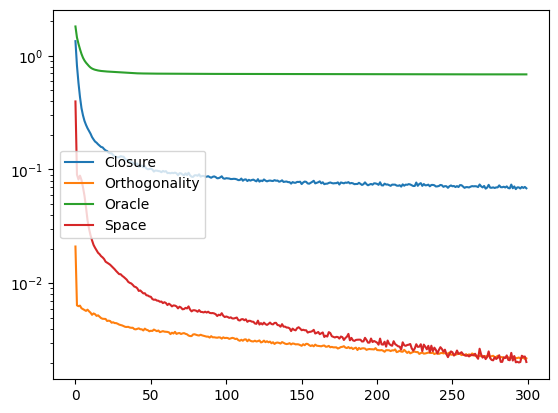

In [11]:
plt.plot(loss_S_closure, label =  "Closure")
plt.plot(loss_S_orth, label =  "Orthogonality")
plt.plot(loss_oracle, label =  "Oracle")
plt.plot(loss_space, label =  "Space")
plt.yscale("log")
plt.legend()

In [12]:
X, Y = next(iter(train_dataloader_Z))
X = X.to(device)
theta = 2*torch.ones(X.shape[0]) - 1 #Sampling
zero = torch.zeros(X.shape[0], device = device)
theta = theta.to(device)


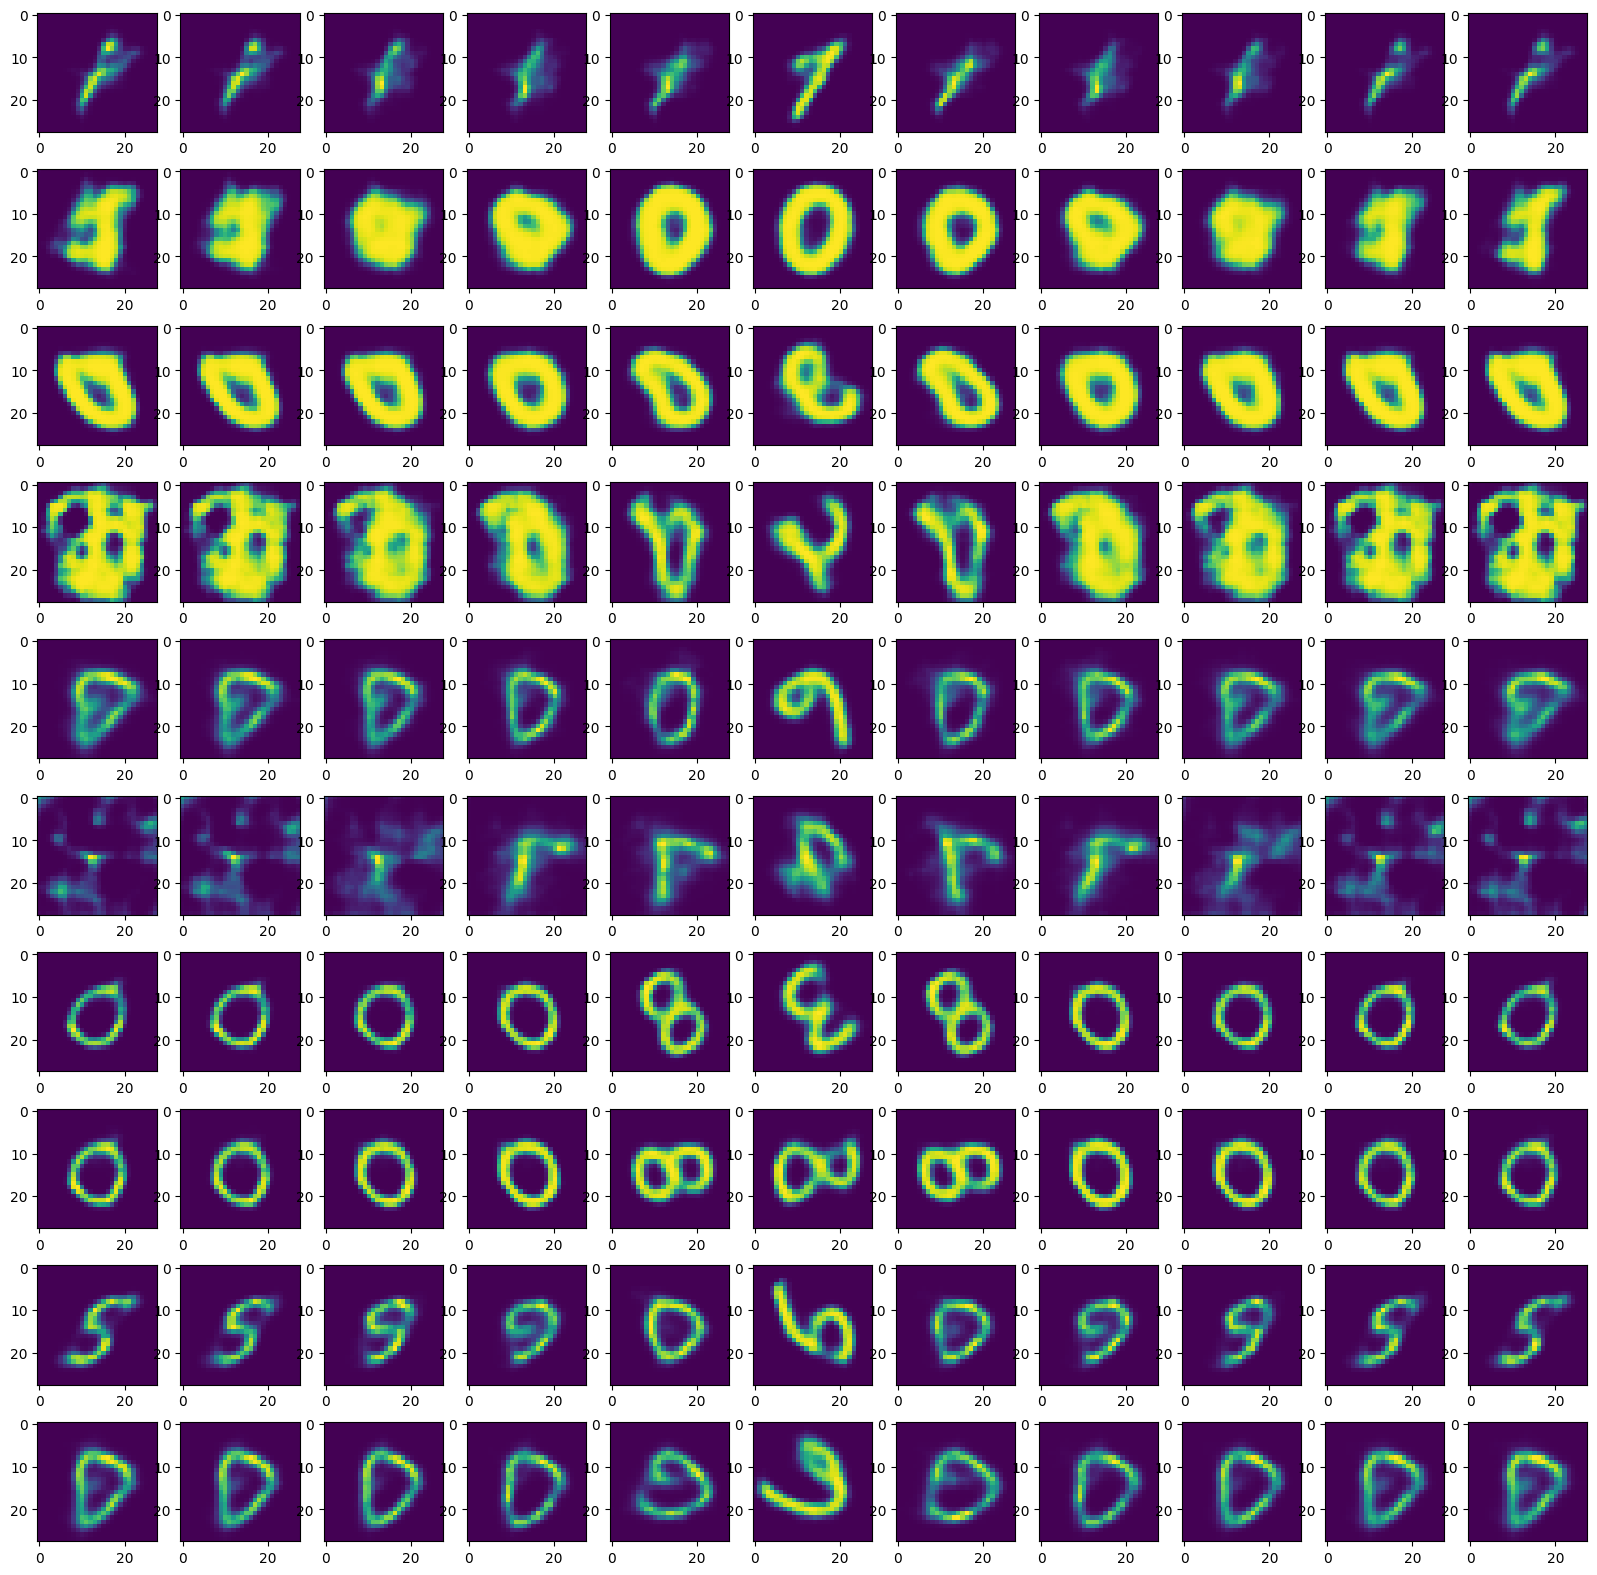

In [13]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([theta*(step),zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

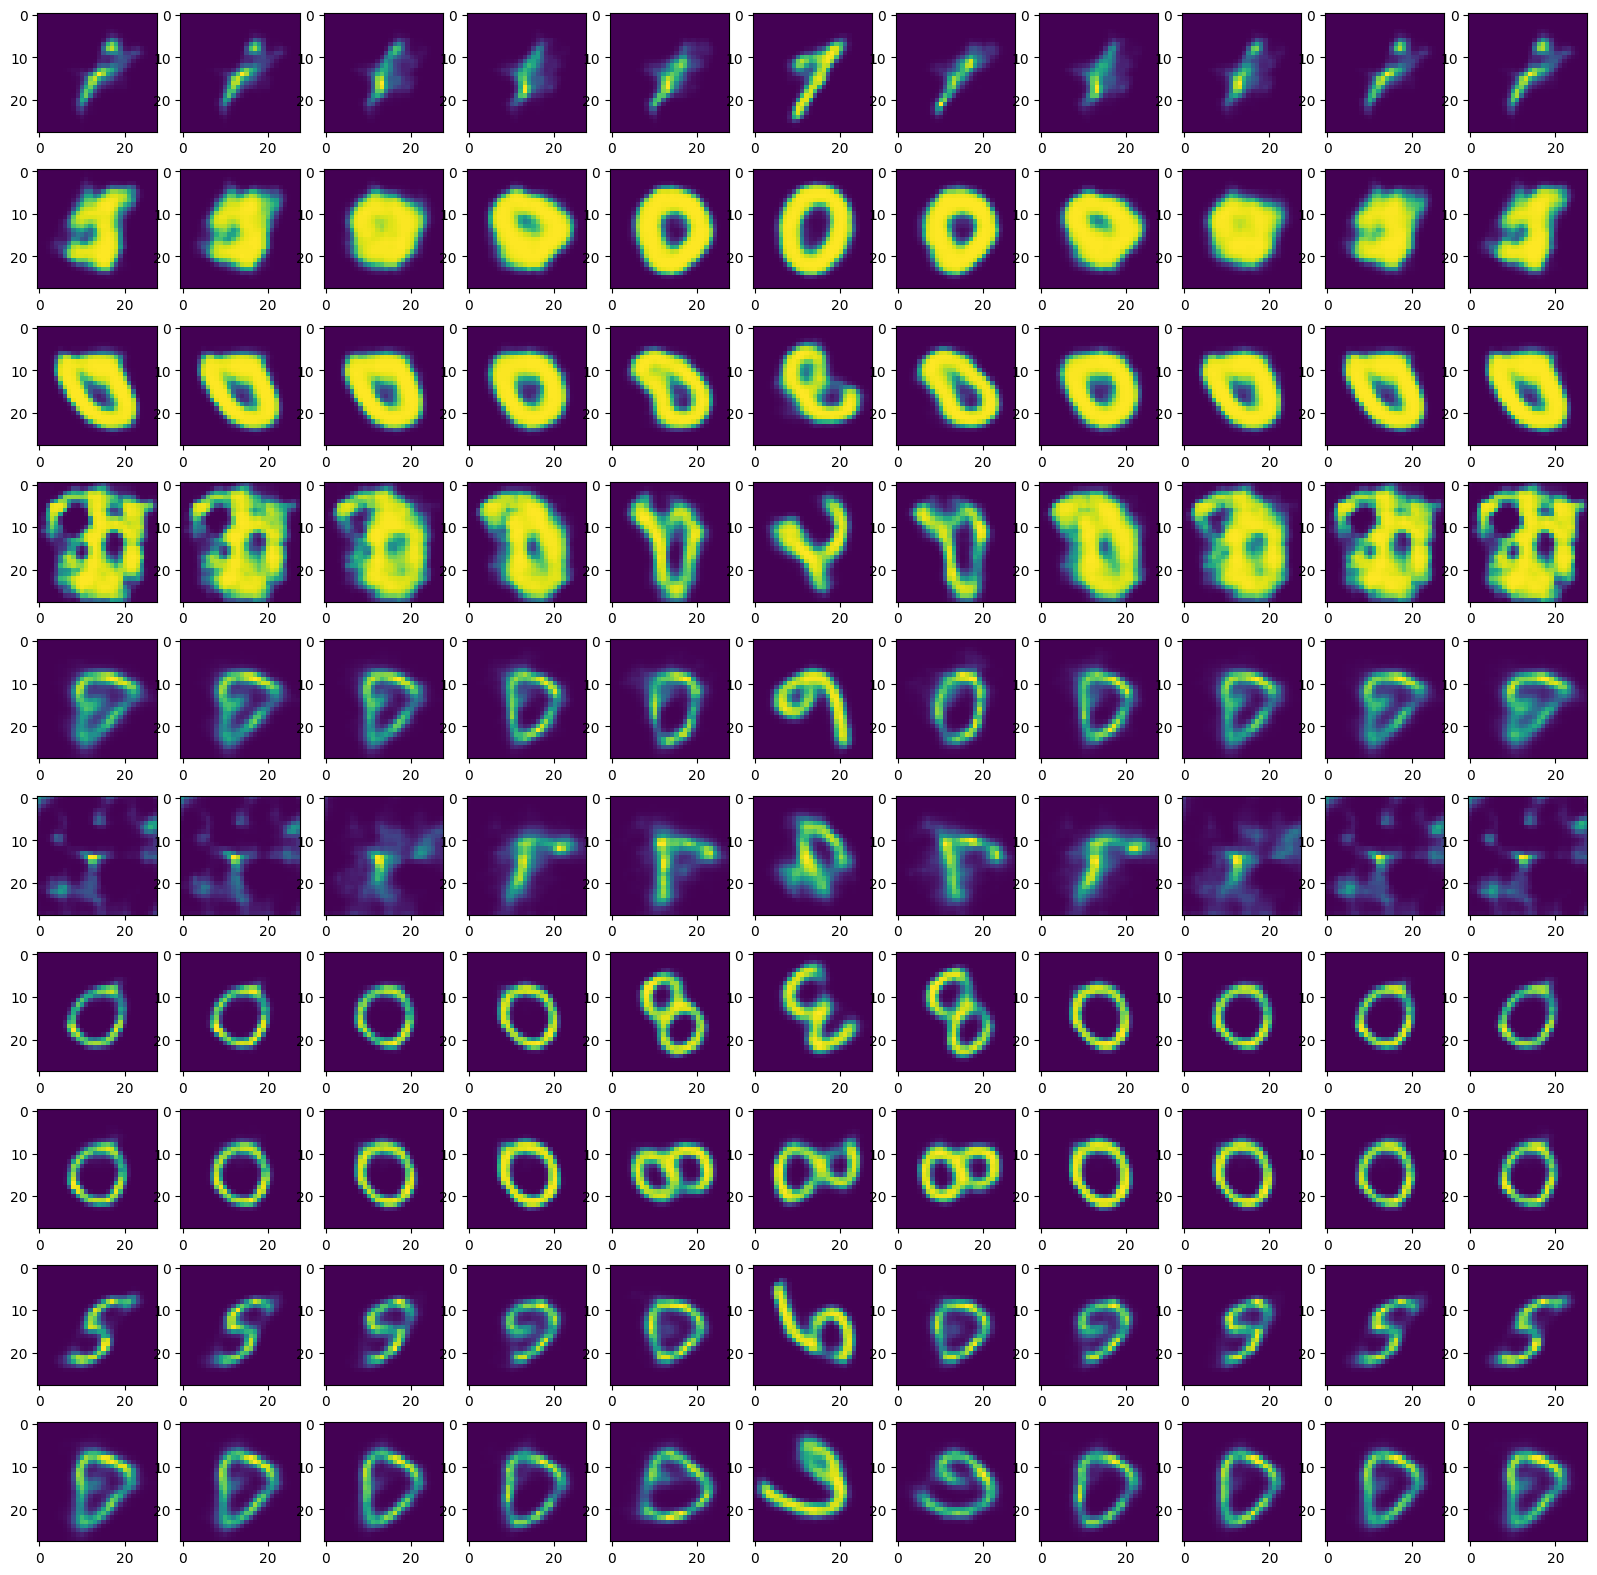

In [14]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,theta*(step),zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

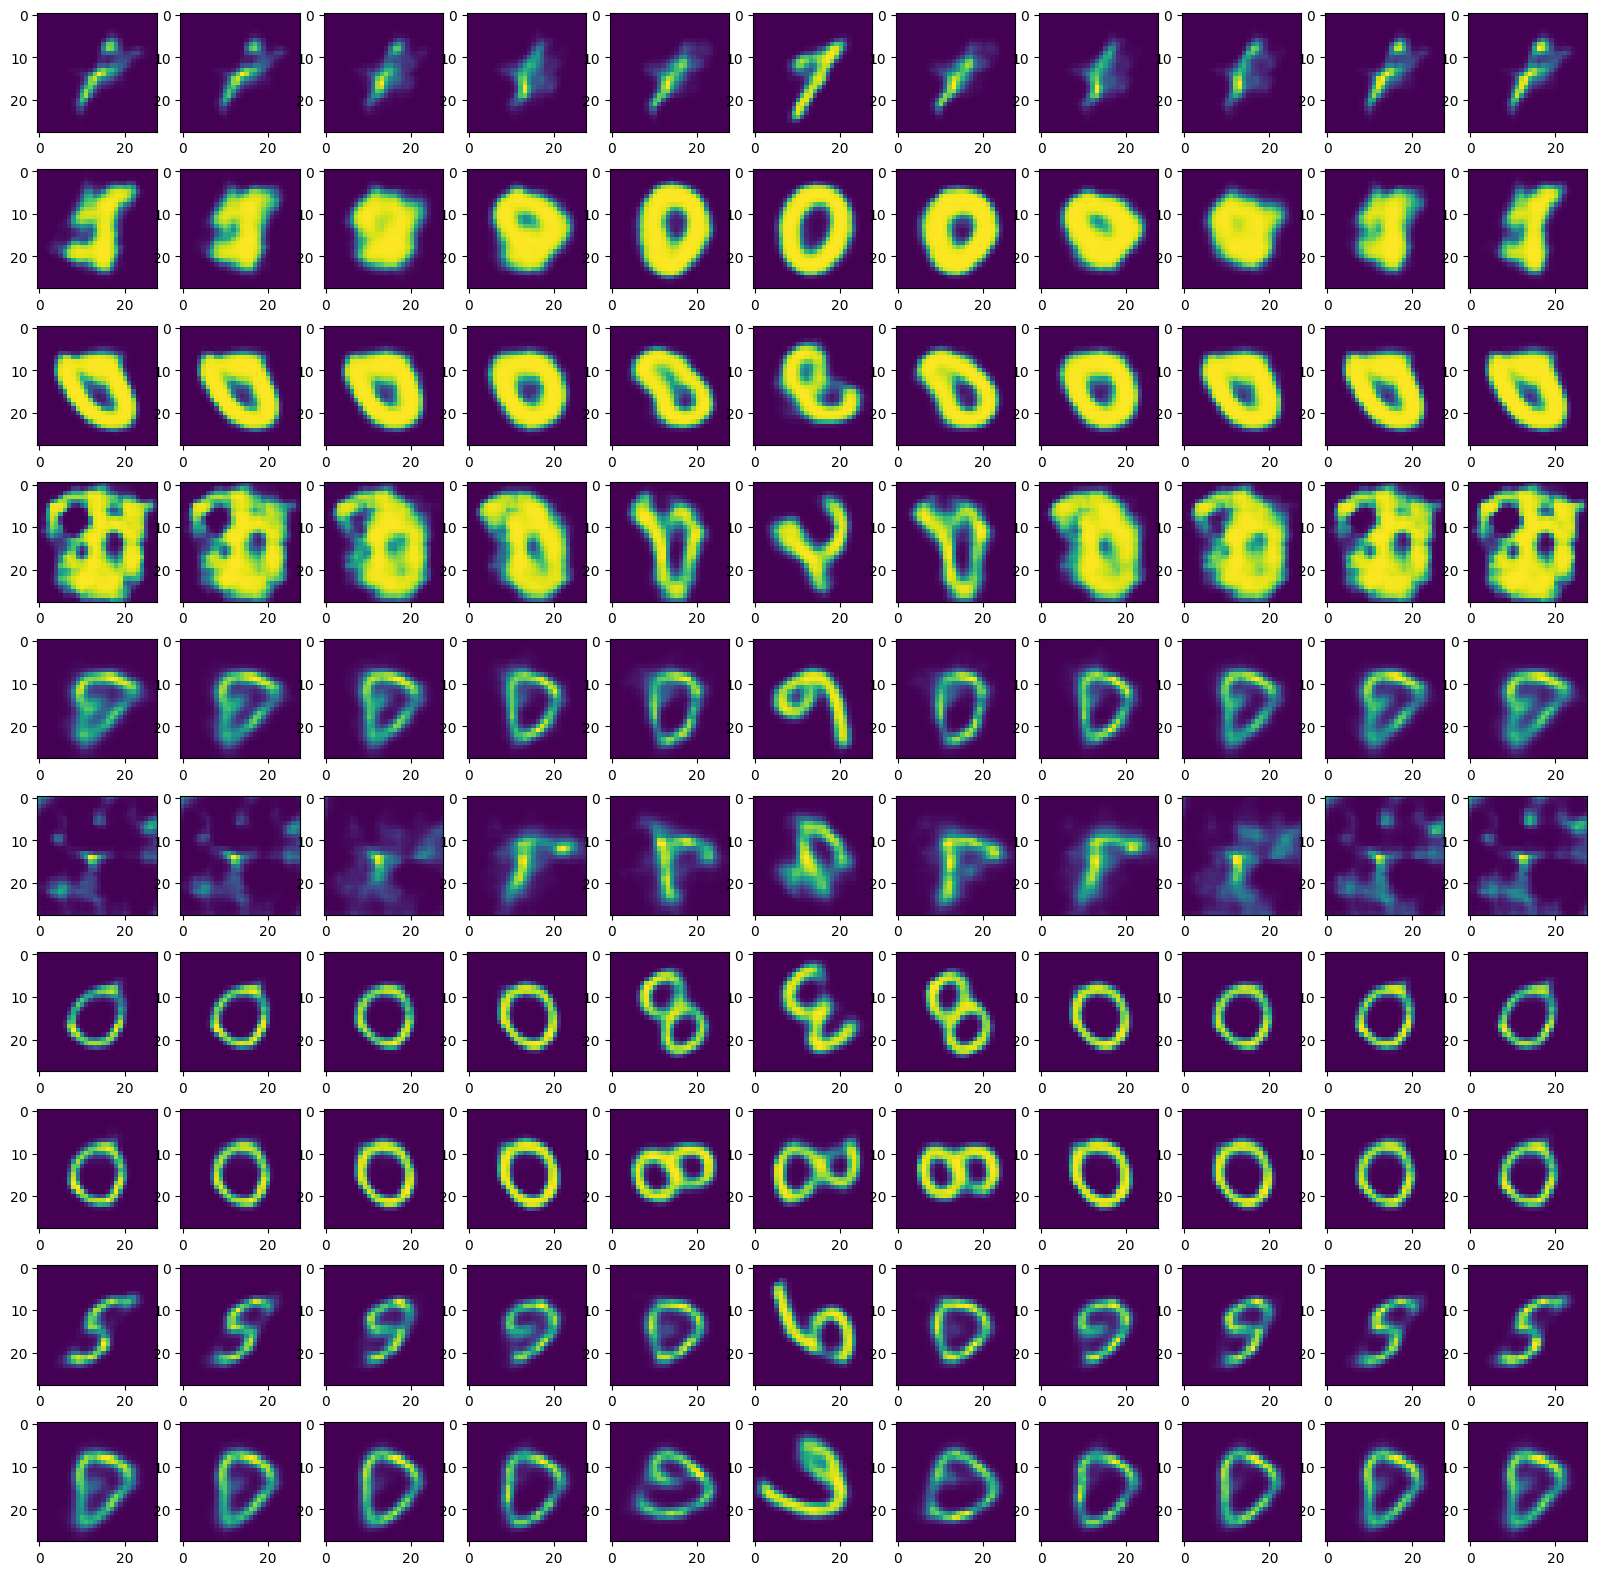

In [15]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,zero,theta*(step)],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

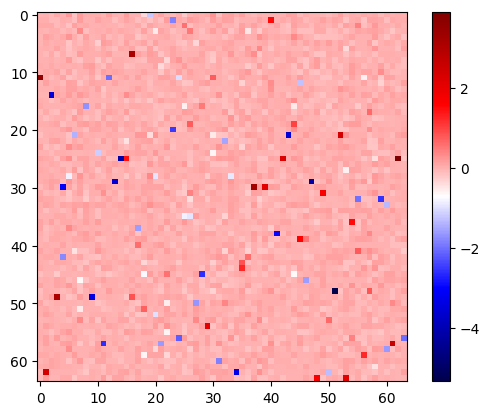

In [53]:
plt.imshow(model_symmetry.group[0].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

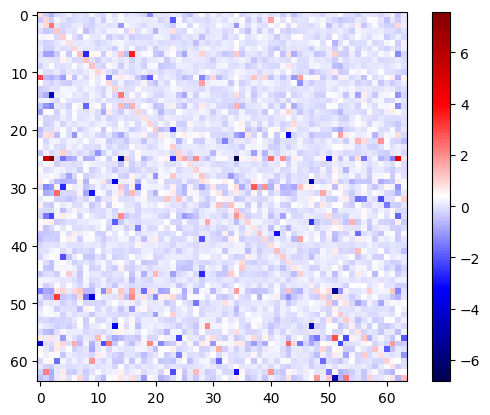

In [54]:
plt.imshow(torch.matrix_exp(model_symmetry.group[0].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

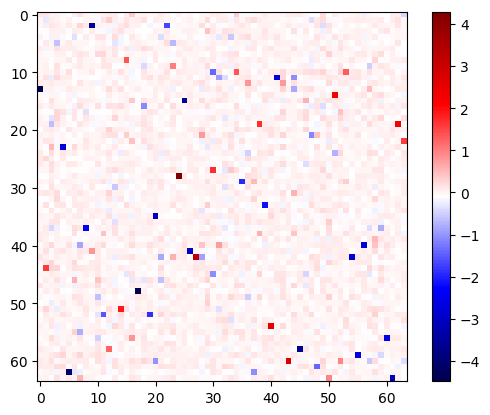

In [55]:
plt.imshow(model_symmetry.group[1].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

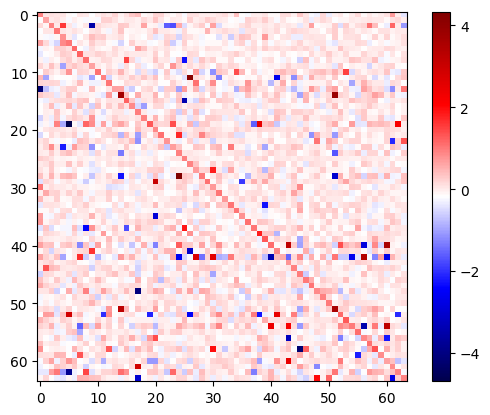

In [56]:
plt.imshow(torch.matrix_exp(model_symmetry.group[1].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

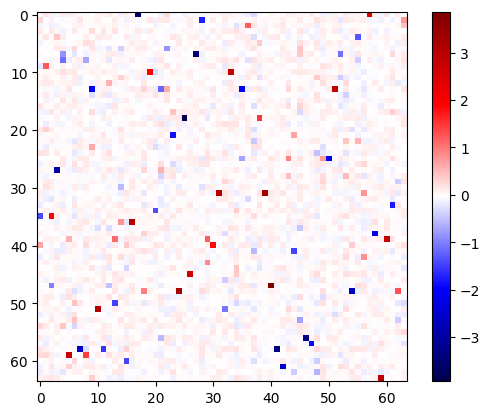

In [57]:
plt.imshow(model_symmetry.group[2].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

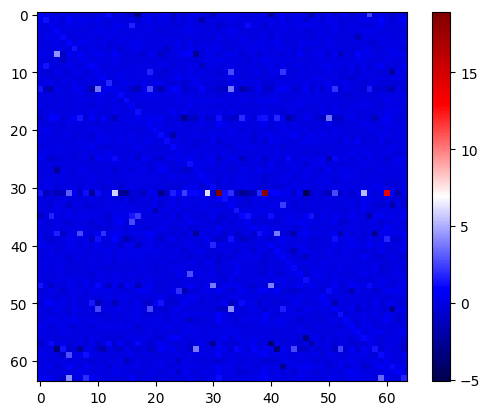

In [58]:
plt.imshow(torch.matrix_exp(model_symmetry.group[2].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()